In [1]:
import copy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

In [4]:
# Функция для отрисовки графика.
def drawing_graph(data, size, name, ox, oy):
    plt.figure(figsize=size)
    plt.plot(data)
    plt.title(name)
    plt.xlabel(ox)
    plt.ylabel(oy)
    plt.show()
    

# Функция для отрисовки цикла дыхания с конкретным breath_id 
def process_visualisation(df, breath_id):
    plt.figure(figsize=(14, 6))
    plt.title('breath_id - {}'.format(breath_id))
    x = df[df['breath_id'] == breath_id]['time_step']
    y = df[df['breath_id'] == breath_id]['pressure']
    plt.plot(x, y, '-', label=y.name)
    plt.grid()
    plt.legend()
    plt.ylabel('Value')
    plt.show()
    
    
# Функция для отрисовки матрицы корреляции столбцов датафрейма.    
def show_correlogram(df):
    plt.figure(figsize=(12,12), dpi= 80)
    sns.heatmap(
        df.corr(), xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, center=0, annot=True, cbar=False
    )
    plt.title('Корреляция между признаками', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=12)
    plt.show()
    

# Функция для нахождения 1 и 3 квантиля, межквартильного расстояния и правого края усов.    
def find_moustache(data):
    
    # Найдем значение квантилей.
    q1 = int(data.quantile([0.25]))
    q3 = int(data.quantile([0.75]))
    print("Первый квантиль = ", q1)
    print("Третий квантиль = ", q3)
    
    # найдем межквартильное расстояние
    iqr = q3 - q1
    print("Межквартильное расстояние = ", iqr)
    
    # Найдем правый край усов
    q_moustache = q3 + 1.5*iqr
    print("Правый край усов = ", q_moustache)
    
    return q_moustache

### Загрузим наши данные и посмотрим на них.


In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample = pd.read_csv('sample_submission.csv')

In [8]:
df_train

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938


In [9]:
df_test

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0
...,...,...,...,...,...,...,...
4023995,4023996,125748,20,10,2.530117,4.971245,1
4023996,4023997,125748,20,10,2.563853,4.975709,1
4023997,4023998,125748,20,10,2.597475,4.979468,1
4023998,4023999,125748,20,10,2.631134,4.982648,1


In [10]:
df_sample

,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
4023995,4023996,0
4023996,4023997,0
4023997,4023998,0
4023998,4023999,0


## Анализ таргета
Нашим таргетом является столбец pressure. Расмотрим его подробнее. Сначала посмотрим статистики по нему через pandas. Потом построим по нему диаграммы и графики для визуализации его значений.

In [11]:
df_train["pressure"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 6036000 entries, 0 to 6035999
Series name: pressure
Non-Null Count    Dtype  
--------------    -----  
6036000 non-null  float64
dtypes: float64(1)
memory usage: 46.1 MB


In [12]:
df_train["pressure"].describe()

count    6.036000e+06
mean     1.122041e+01
std      8.109703e+00
min     -1.895744e+00
25%      6.329607e+00
50%      7.032628e+00
75%      1.364103e+01
max      6.482099e+01
Name: pressure, dtype: float64

Среди статистик таргета стоит обратить внимание на минимум. Он отрицательный. Отрицательное давление. Чуть ниже мы еще вернемся к этому вопросу.

In [13]:
df_train["pressure"].value_counts()

pressure
 6.399909     198642
 6.470211     188844
 6.329607     180688
 6.259305     180582
 6.610815     164401
               ...  
 62.711927         6
 62.641625         5
 63.274345         4
 62.360417         3
-1.895744          3
Name: count, Length: 950, dtype: int64

In [18]:
df_train["pressure"].value_counts(bins=3)

pressure
(-1.9629999999999999, 20.343]    5155414
(20.343, 42.582]                  858154
(42.582, 64.821]                   22432
Name: count, dtype: int64

Визуализируем значения таргета.

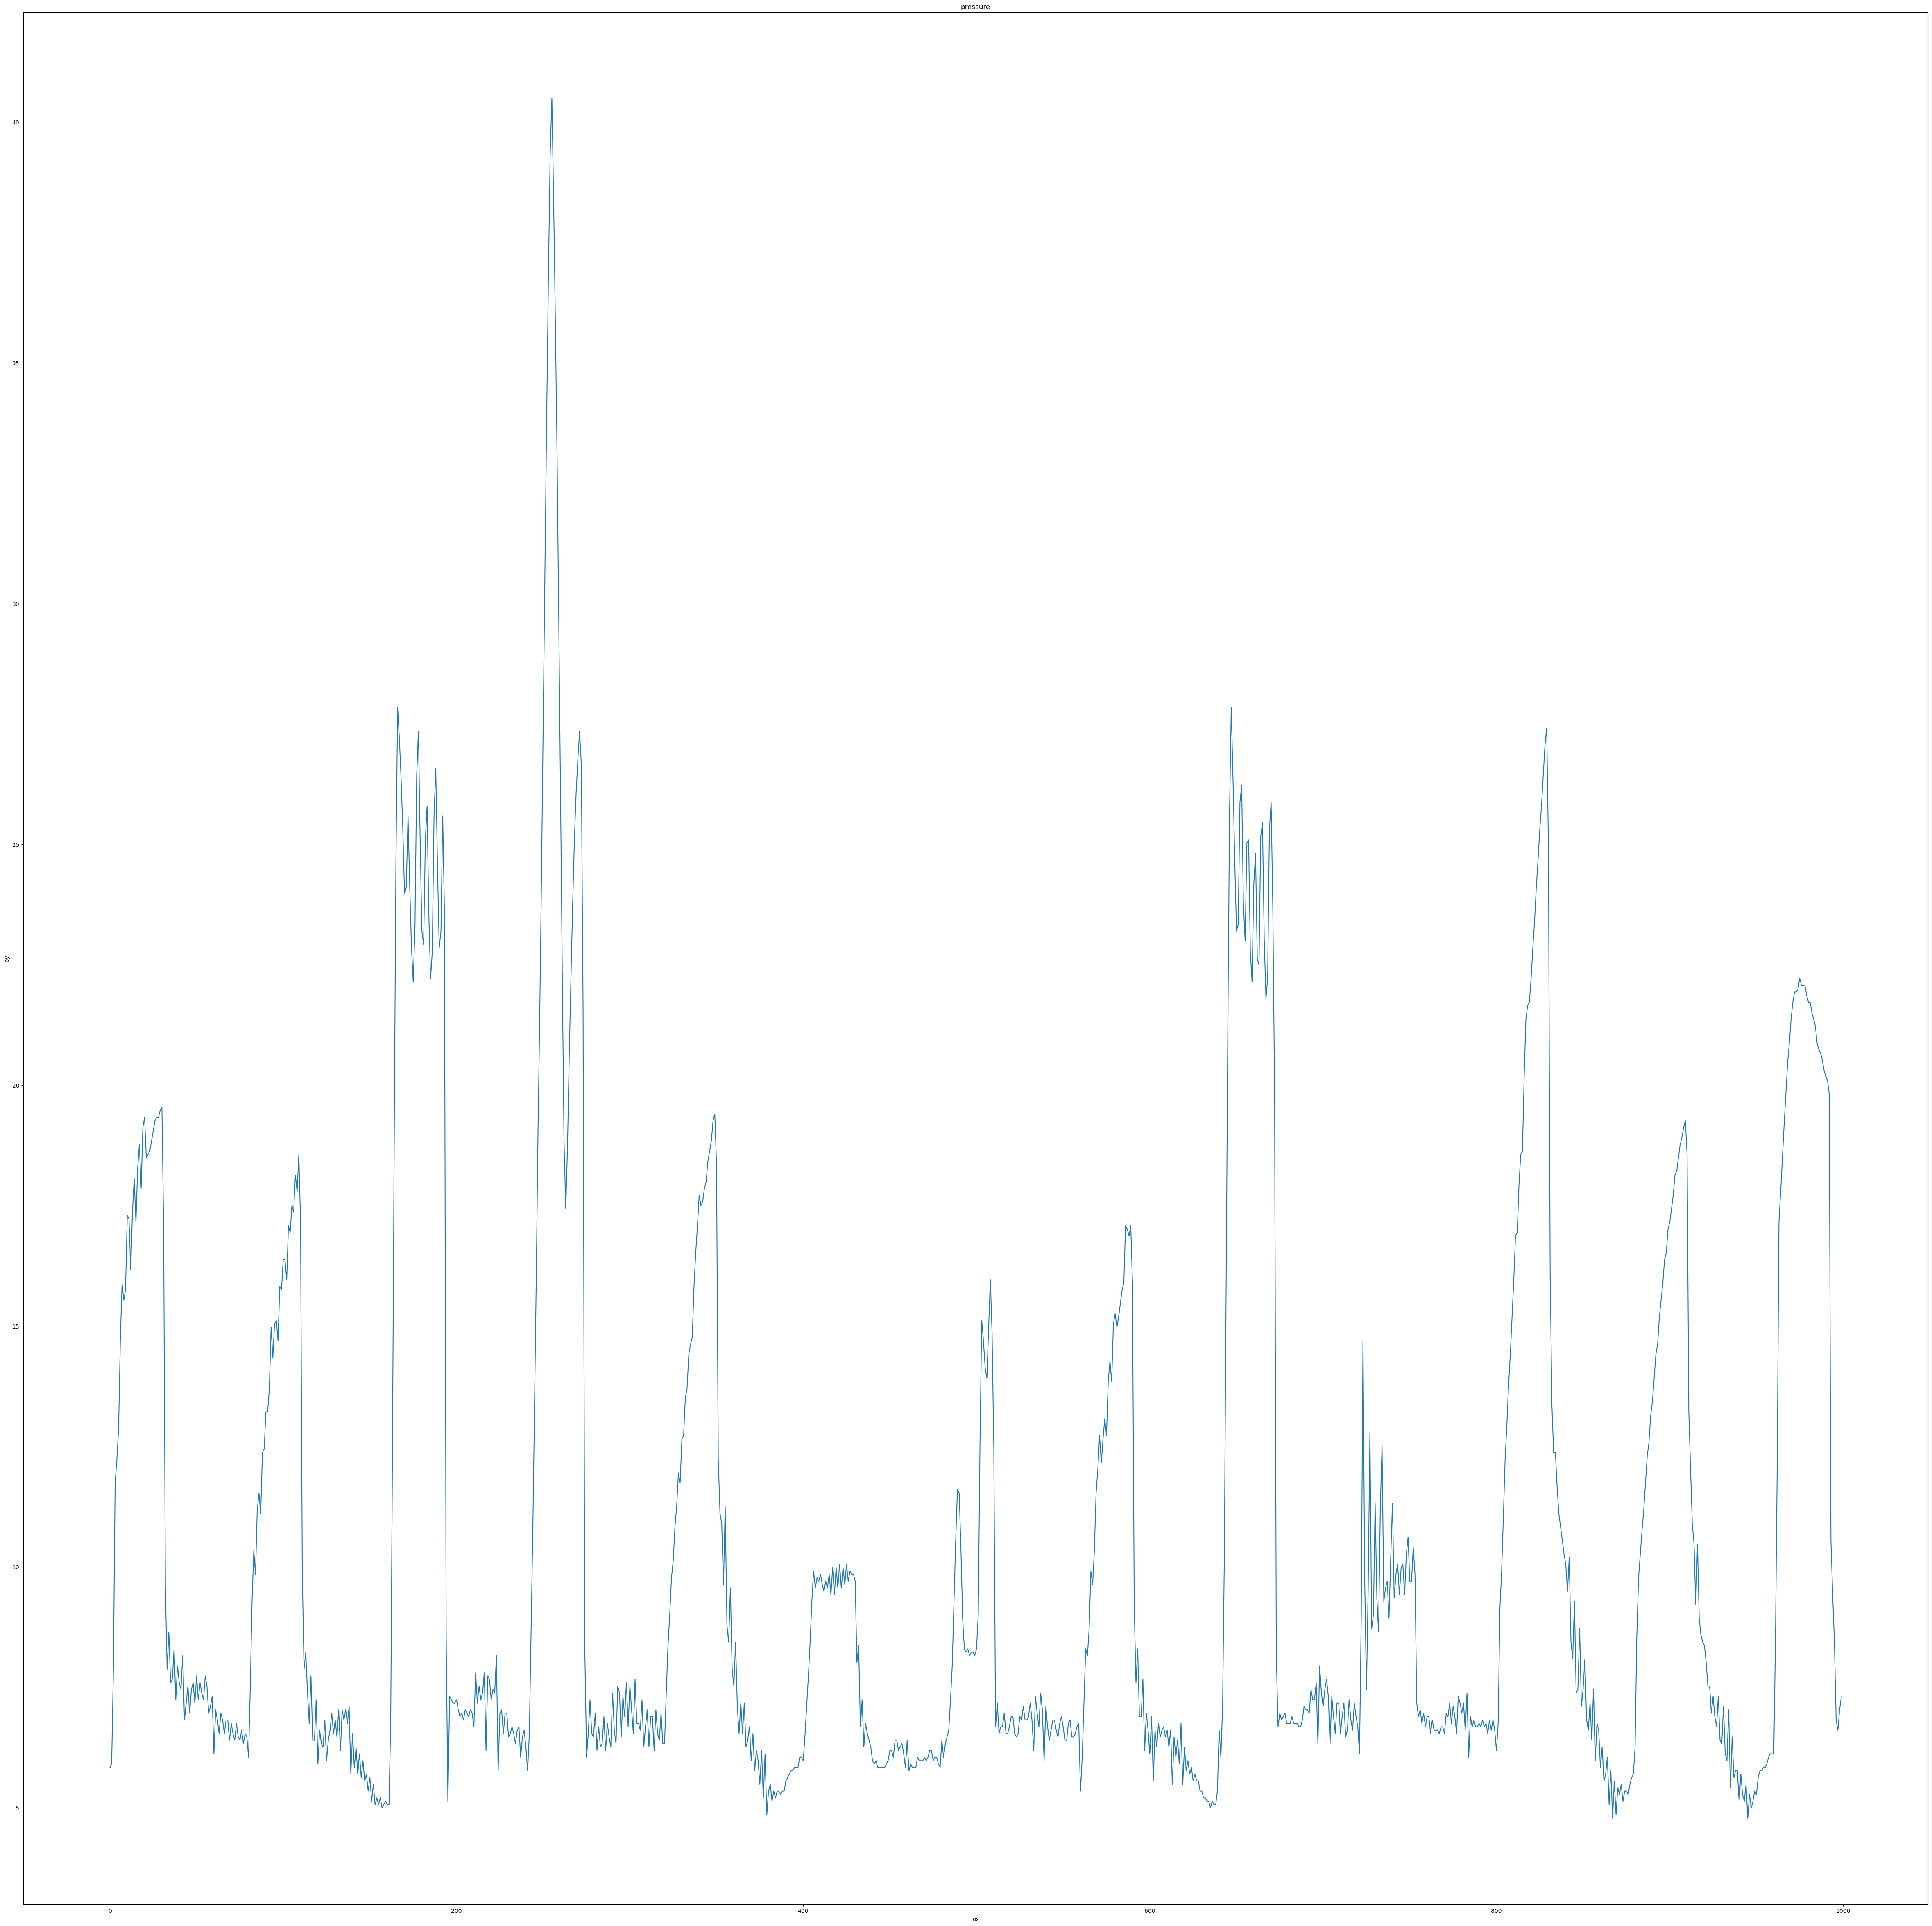

In [23]:
# Выведем на графике первые 1000 значений таргета просто чтобы посмотреть, как он выглядит.
drawing_graph(df_train["pressure"].iloc[:1000], [60,60], "pressure", "ox", "oy")

Видим цикличное повышение и понижение давления в циклах дыхания.

<Axes: xlabel='pressure', ylabel='Count'>

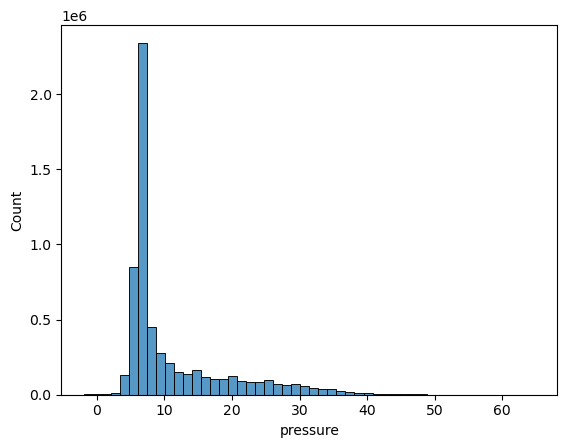

In [25]:
# Построим гистограмму таргета на всех данных трейна.
sns.histplot(df_train["pressure"], bins=50)

In [26]:
# Найдем среднее значение таргета для каждого из 75450 циклов дыхания.
pressure_mean = df_train.groupby(["breath_id"]).agg("mean")["pressure"]

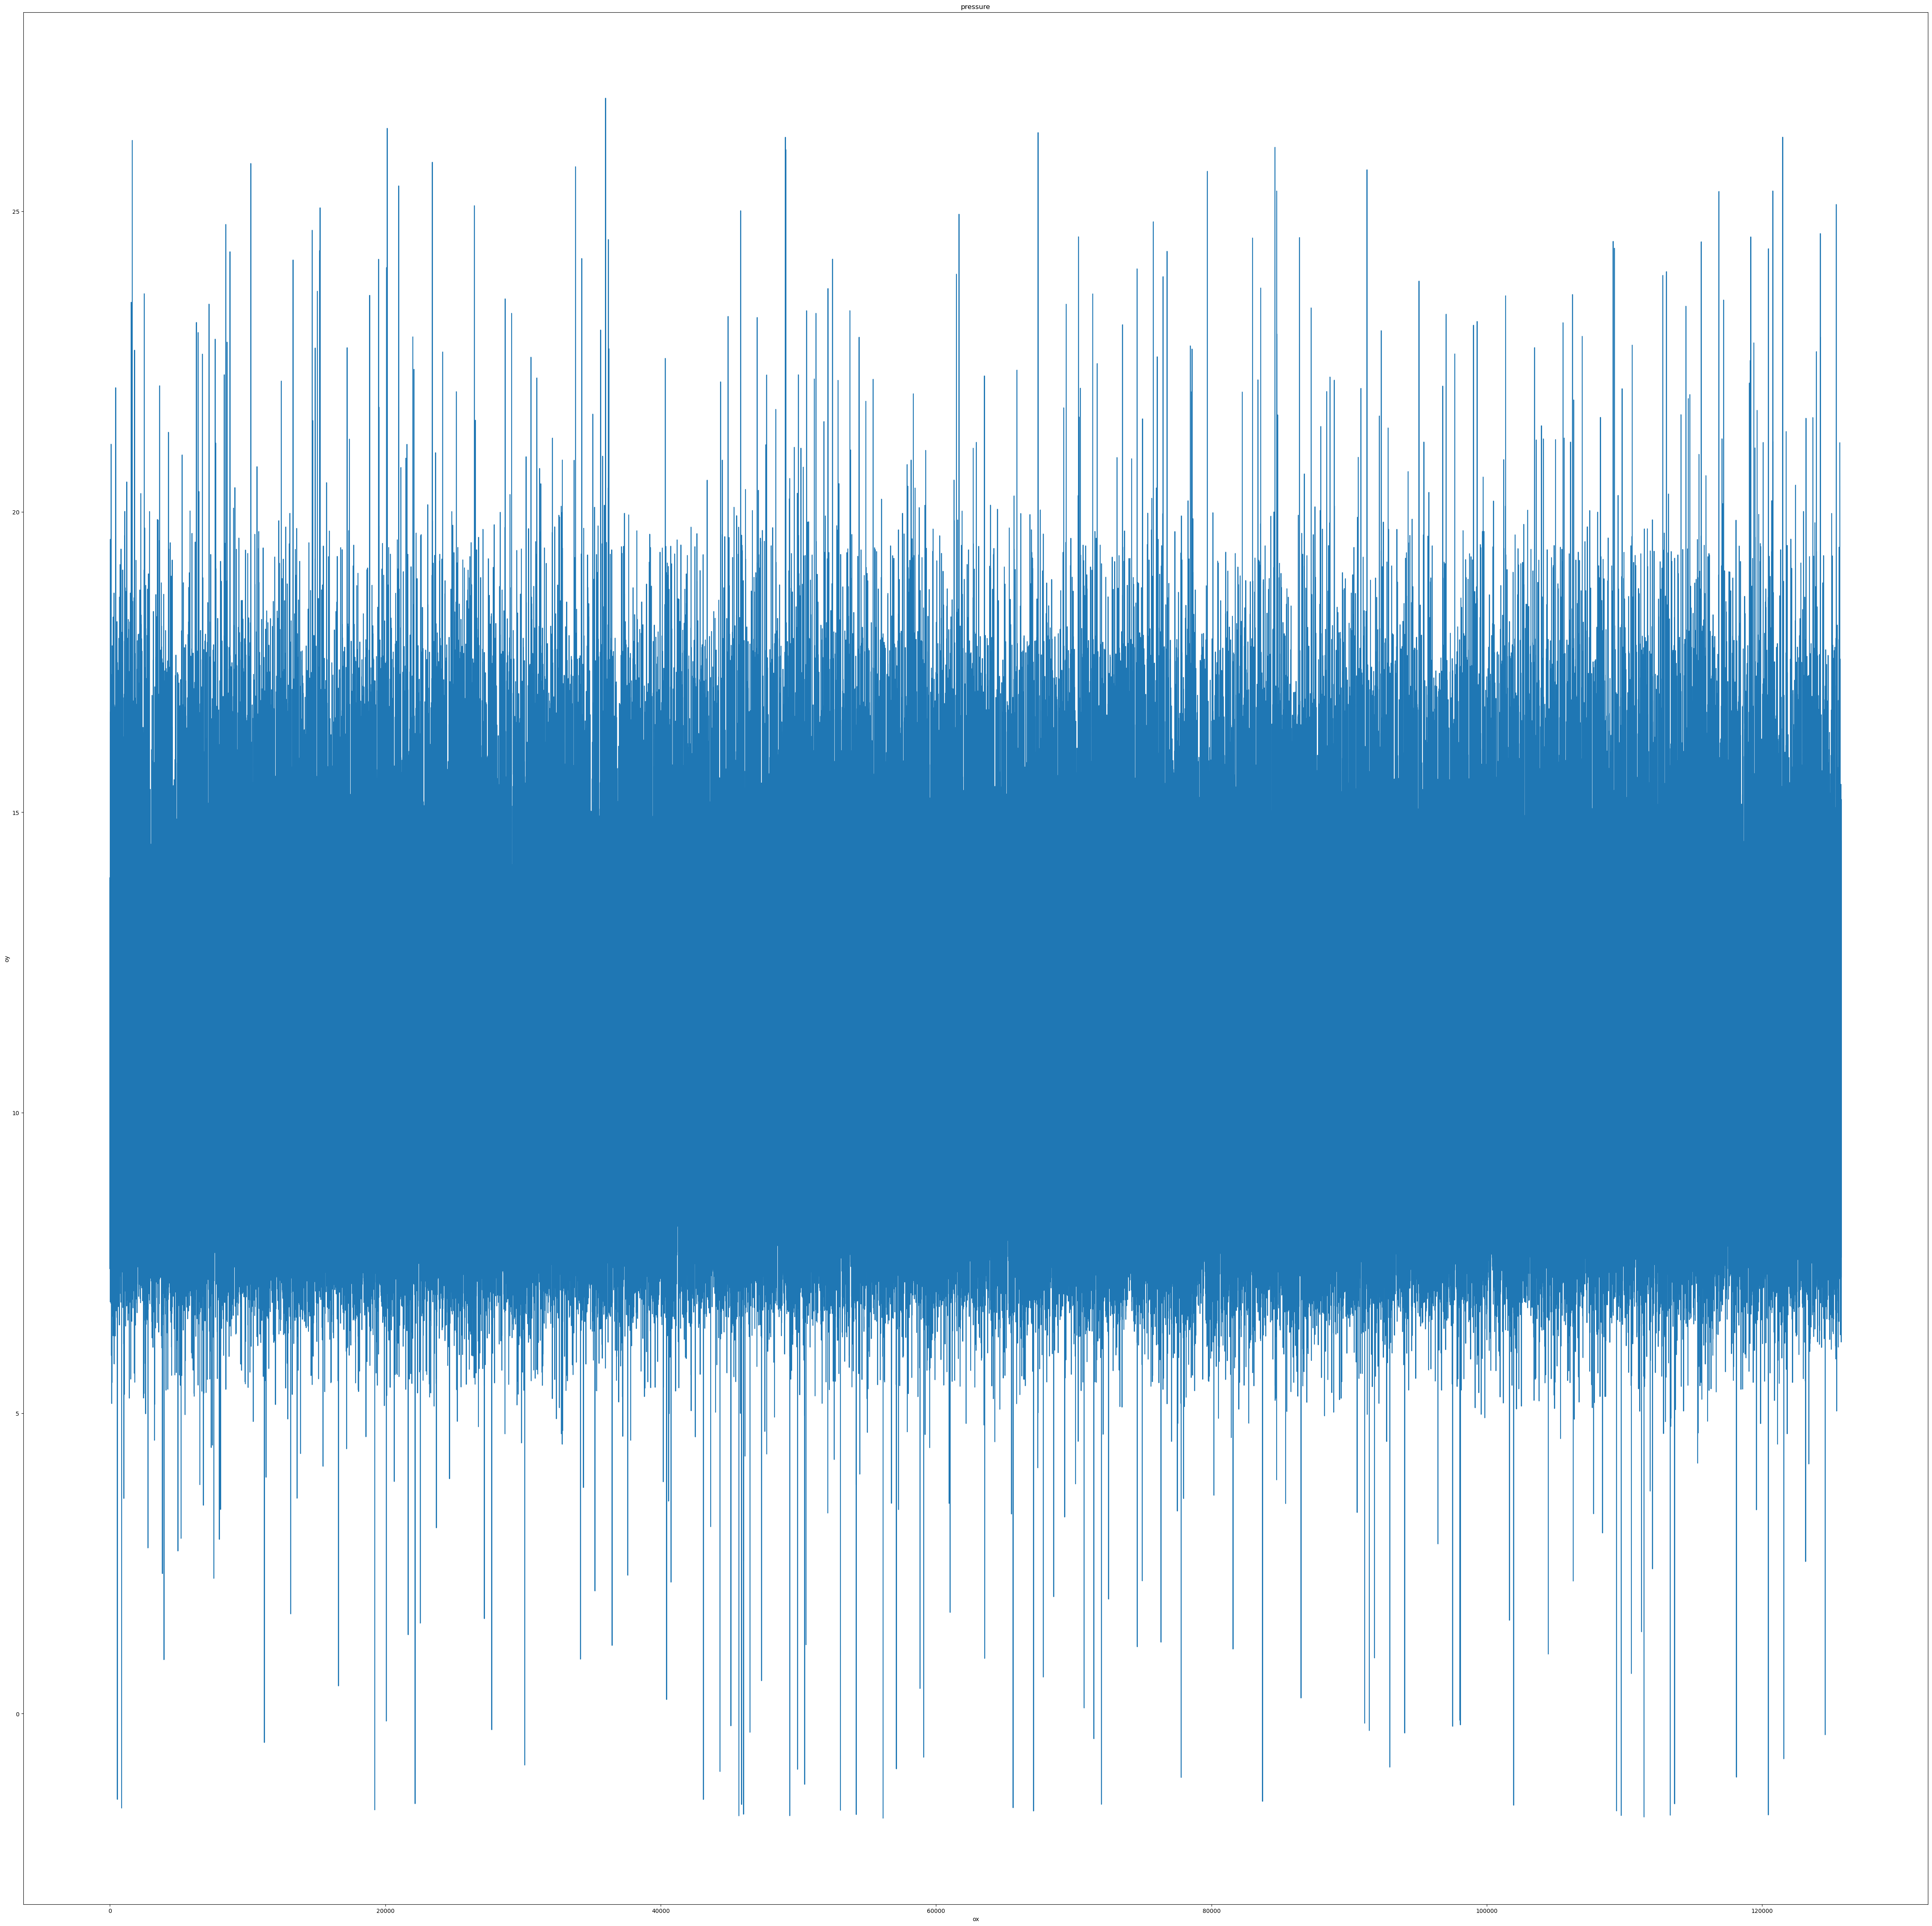

In [32]:
# Выведем на графике средние значения таргета по циклам дыхания.
drawing_graph(pressure_mean, [60,60], "pressure", "ox", "oy")

In [6]:
# Найдем стандартное отклонение таргета для каждого из 75450 циклов дыхания.
pressure_std = df_train.groupby(["breath_id"]).agg("std")["pressure"]

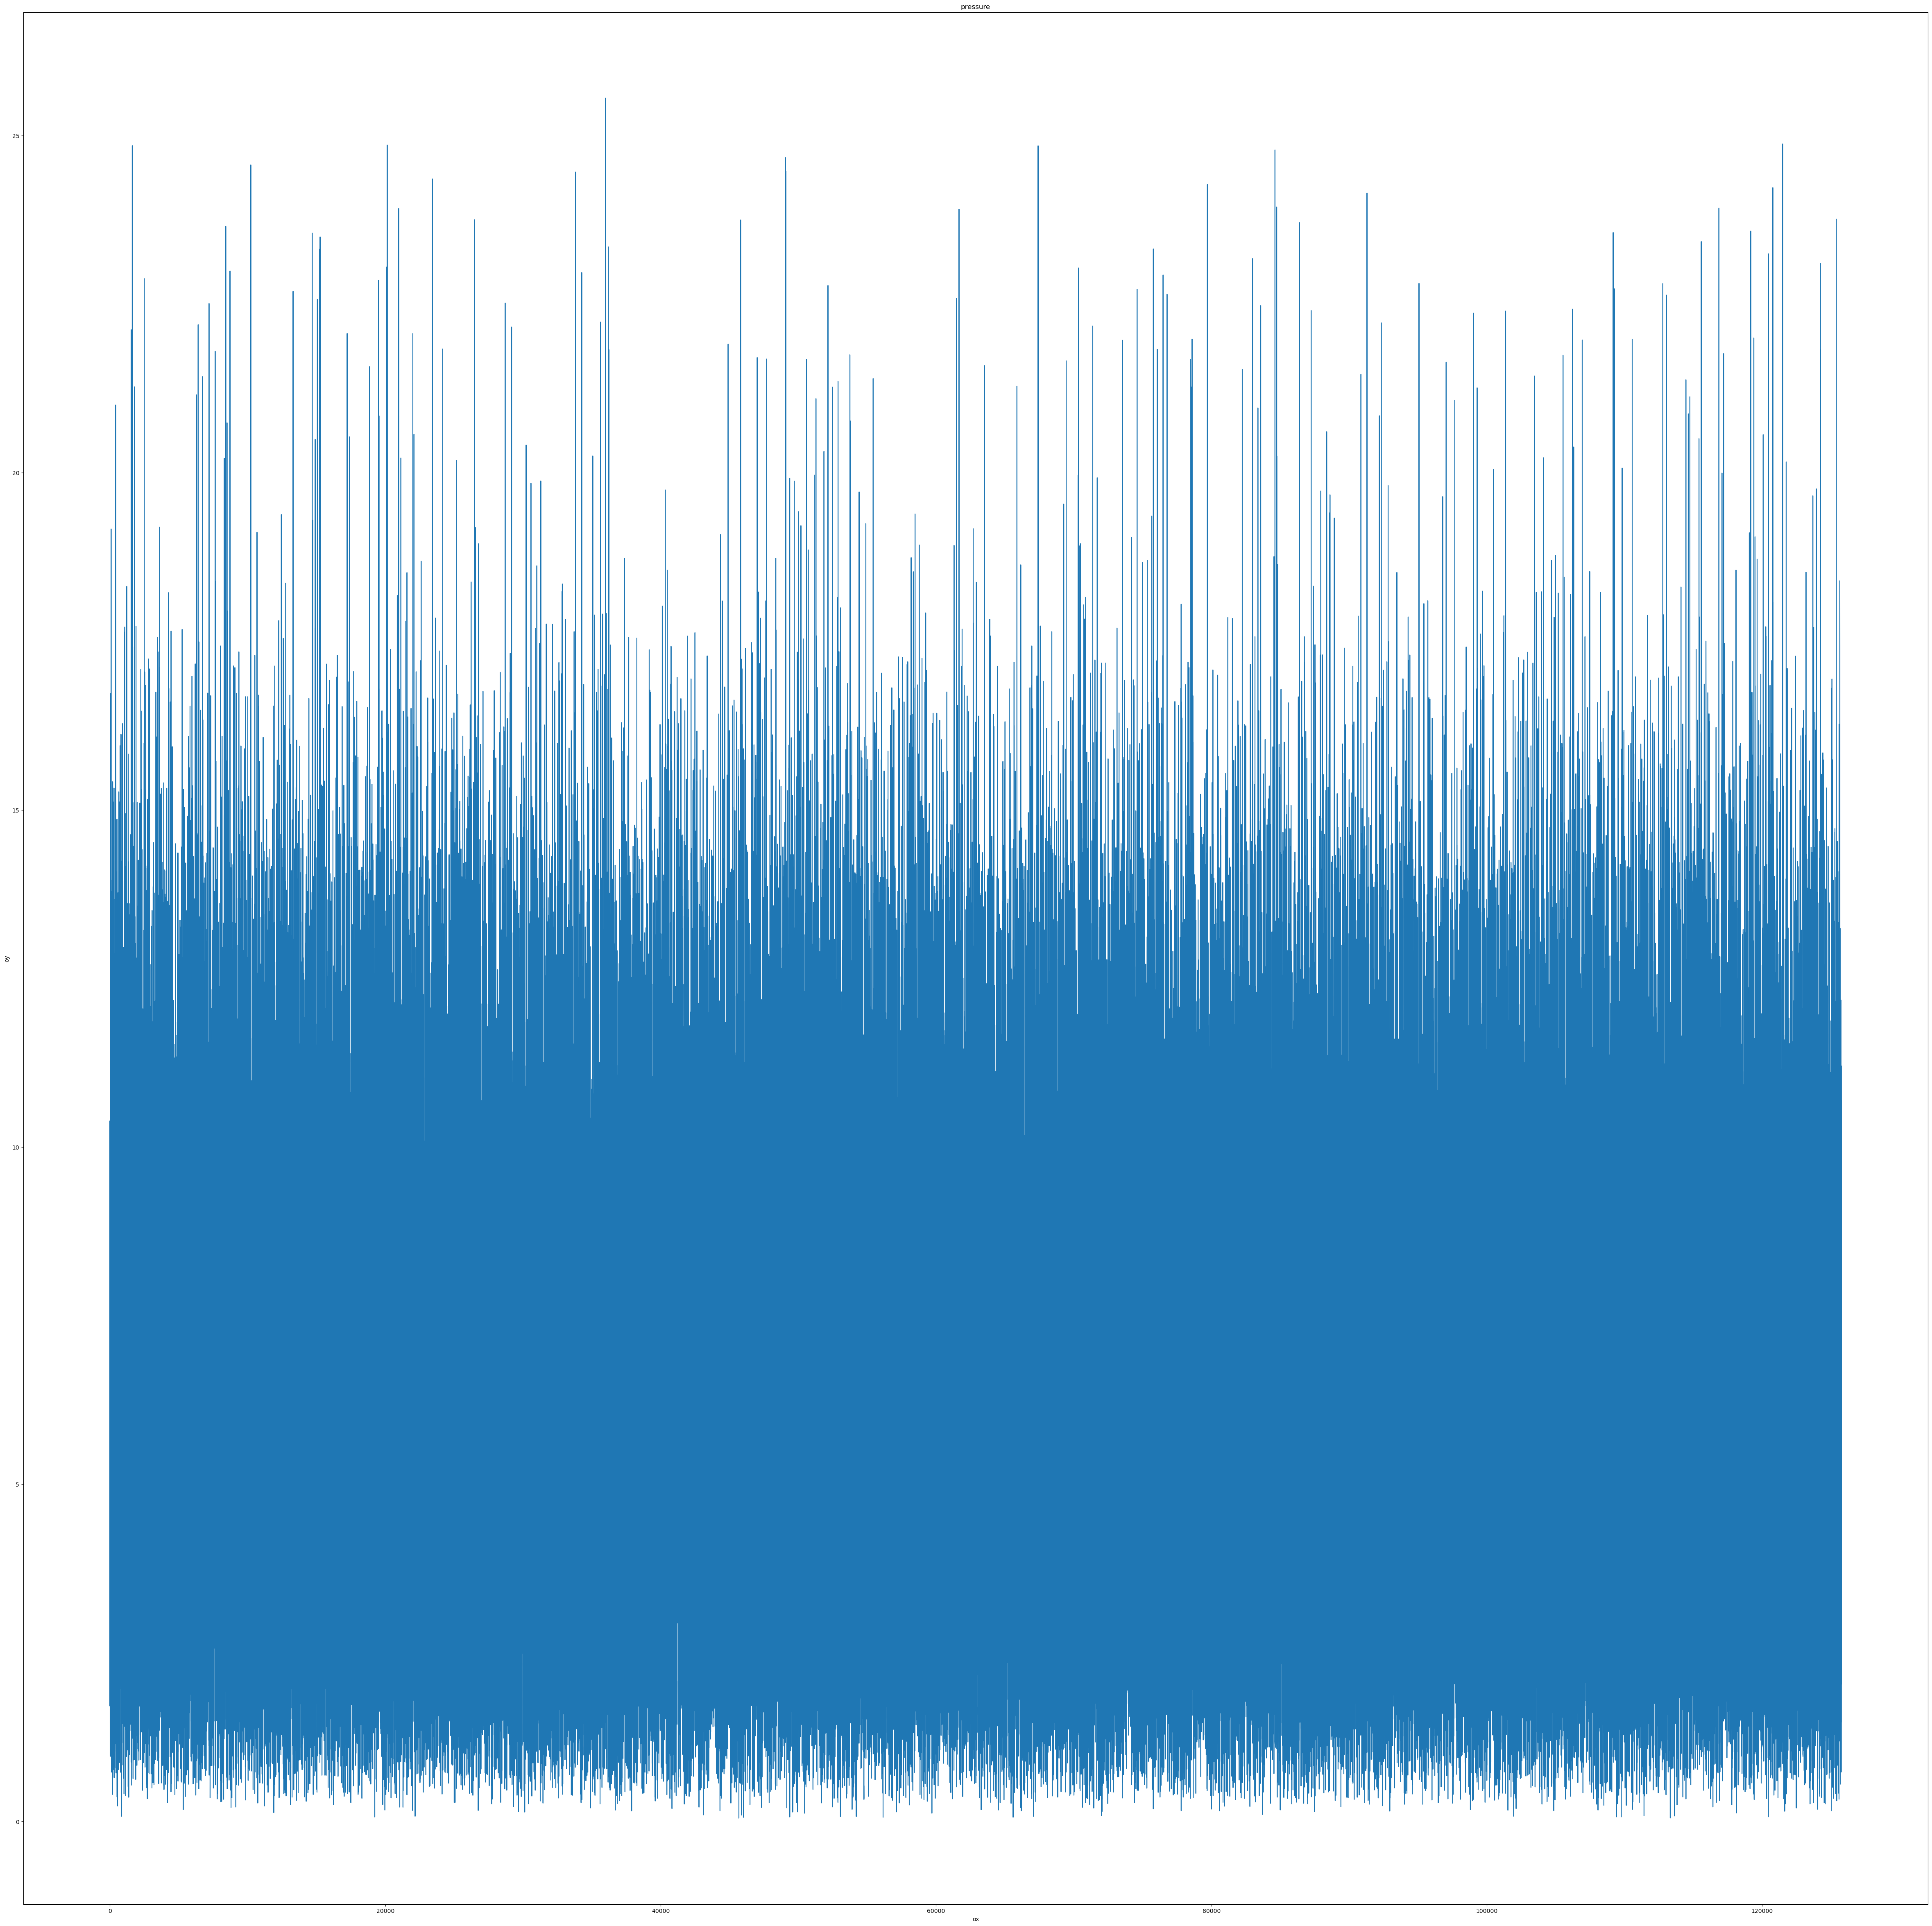

In [7]:
# Выведем на графике стандарные отклонения таргета по циклам дыхания.
drawing_graph(pressure_std, [60,60], "pressure", "ox", "oy")

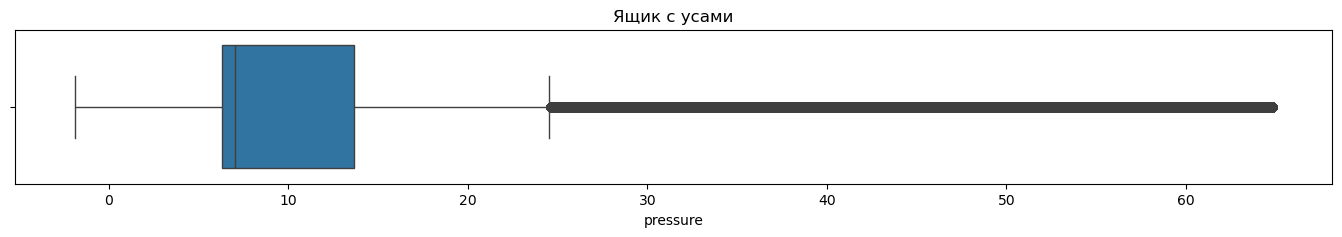

In [37]:
# Теперь посмотрим ящик с усами.
plt.figure(figsize=(17, 2))
sns.boxplot(data = df_train[["pressure"]], x='pressure')
plt.title('Ящик с усами')
plt.show()

In [38]:
# Найдём правый край усов.
q_moustache = find_moustache(df_train['pressure'])  

Первый квантиль =  6
Третий квантиль =  13
Межквартильное расстояние =  7
Правый край усов =  23.5


In [39]:
# Посмотрим на выбросы в таргете - на значения превышающие правый край усов.
df_train_ejection = df_train[df_train['pressure'] > q_moustache]
df_train_ejection.tail(10)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
6035942,6035943,125749,50,10,0.733832,3.783043,0,27.771761
6035943,6035944,125749,50,10,0.767253,2.438287,0,29.037200
6035944,6035945,125749,50,10,0.800726,2.650333,0,28.755991
6035945,6035946,125749,50,10,0.834147,1.869367,0,29.459013
6035946,6035947,125749,50,10,0.867574,2.154414,0,29.107502
6035947,6035948,125749,50,10,0.900917,1.304434,0,29.880825
6035948,6035949,125749,50,10,0.934309,1.733830,0,29.388710
6035949,6035950,125749,50,10,0.967743,0.958726,0,30.091732
6035950,6035951,125749,50,10,1.001156,1.124068,1,29.529315
6035951,6035952,125749,50,10,1.034688,0.000000,1,29.459013


In [41]:
df_train_ejection["breath_id"].value_counts()

breath_id
4384      32
15502     32
47127     32
41863     32
34409     32
          ..
122651     1
91295      1
122641     1
122639     1
24034      1
Name: count, Length: 38762, dtype: int64

Видим, что ни одно количество breath_id с выбросами не равно 80. Т.е. ни один цикл дыхания не состоит полностью только из выбросов. Также видим, что циклов дыхания с выбросами чуть больше половины от общего количества циклов дыхания 38762 из 75450.

<Axes: xlabel='pressure', ylabel='Count'>

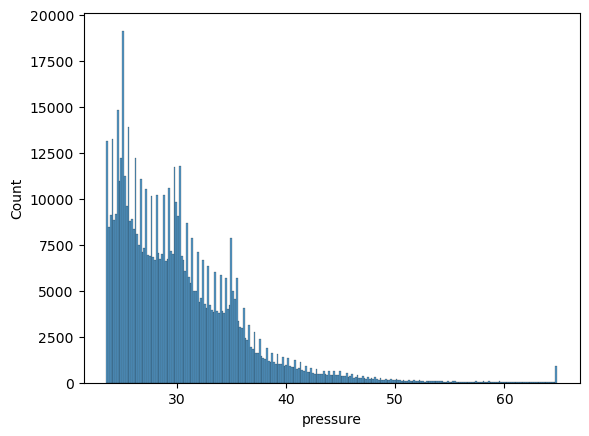

In [43]:
# Построим гистограмму выбросов в pressure.
sns.histplot(df_train_ejection["pressure"])

In [44]:
# Посмотрим на значения без выбросов в таргете
df_train_nonejection = df_train[df_train['pressure'] < q_moustache]
df_train_nonejection.head(10)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
5,6,1,20,50,0.169698,27.259866,0,12.867706
6,7,1,20,50,0.203708,27.127486,0,14.695562
7,8,1,20,50,0.237723,26.807732,0,15.890699
8,9,1,20,50,0.271776,27.864715,0,15.539188
9,10,1,20,50,0.305732,28.313036,0,15.750094


In [47]:
df_train_nonejection["breath_id"].value_counts()

breath_id
1         80
69942     80
69705     80
69709     80
69712     80
          ..
83900     48
113438    48
23949     48
98969     48
40373     48
Name: count, Length: 75450, dtype: int64

<Axes: xlabel='pressure', ylabel='Count'>

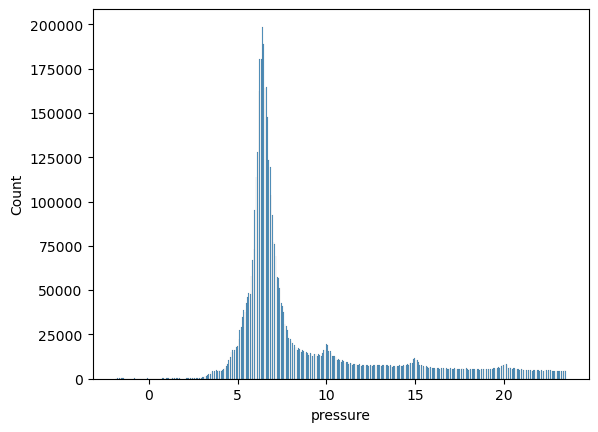

In [45]:
# Построим гистограмму без выбросов в pressure.
sns.histplot(df_train_nonejection["pressure"])

Видим, что есть значения ниже нуля. Т.е. отрицательное давление.

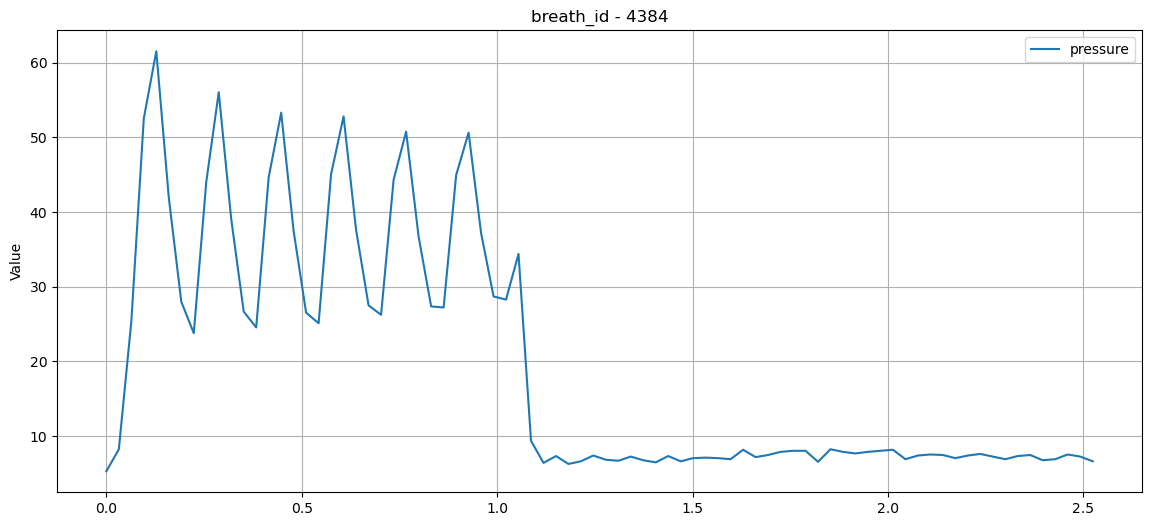

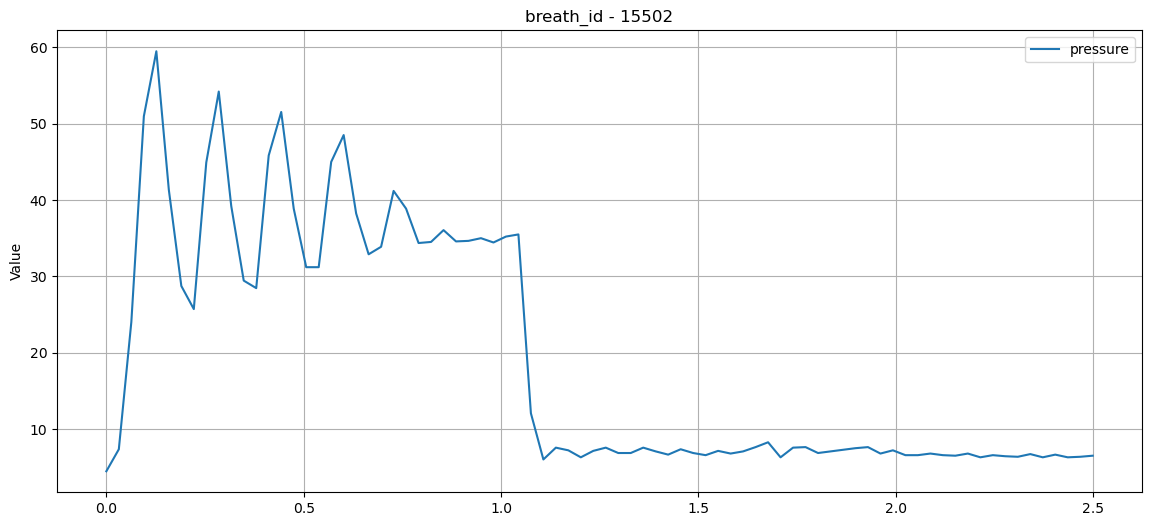

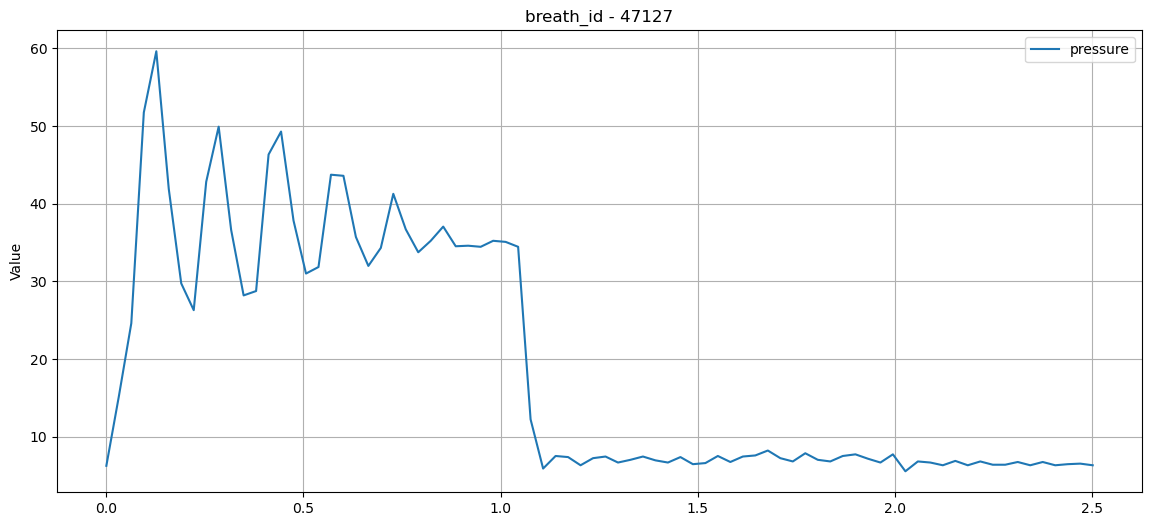

In [50]:
# Посмотрим несколько примеров графиков таргета, где значение таргета превышают правый край усов.
process_visualisation(df_train, 4384)
process_visualisation(df_train, 15502)
process_visualisation(df_train, 47127)

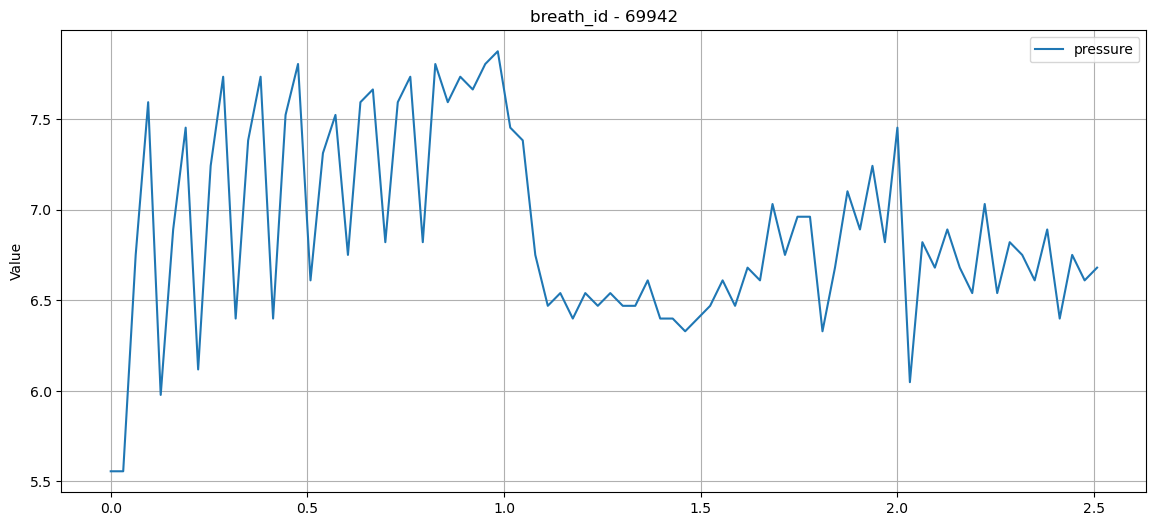

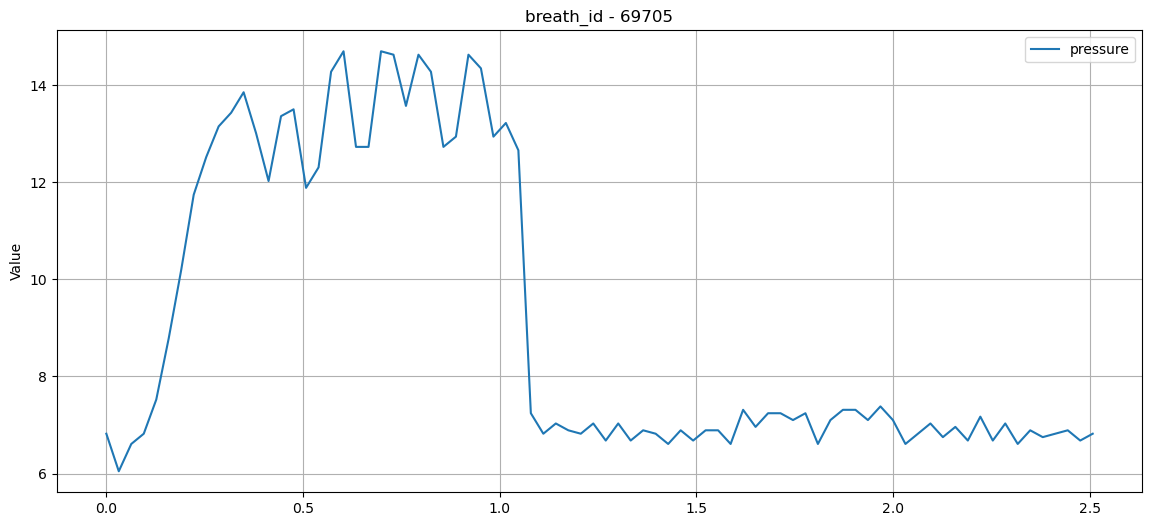

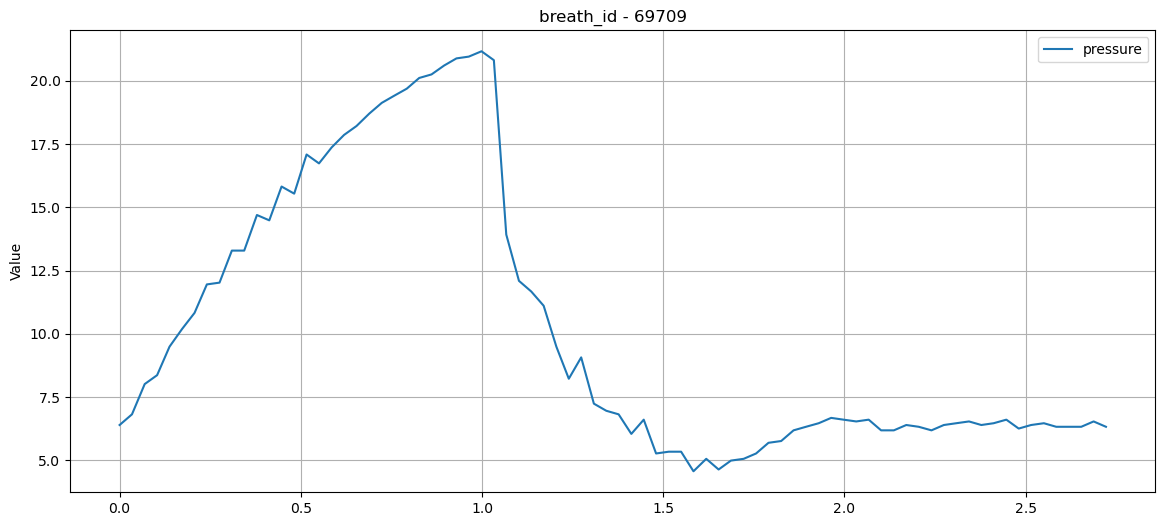

In [48]:
# А теперь посмотрим несколько примеров графика таргета, где значение таргета не превышают правый край усов.
process_visualisation(df_train_nonejection, 69942)
process_visualisation(df_train_nonejection, 69705)
process_visualisation(df_train_nonejection, 69709)

In [51]:
# Посмотрим на значения ниже нуля в таргете.
df_train_subzero = df_train[df_train['pressure'] < 0]
df_train_subzero.head(10)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
28720,28721,542,50,10,0.000000,0.000000,0,-1.825442
28721,28722,542,50,10,0.033468,0.074189,0,-1.825442
28722,28723,542,50,10,0.066892,0.143197,0,-1.755140
28723,28724,542,50,10,0.100245,0.208192,0,-1.825442
28724,28725,542,50,10,0.133618,0.268278,0,-1.684838
28725,28726,542,50,10,0.166979,0.324584,0,-1.684838
28726,28727,542,50,10,0.200405,0.377025,0,-1.614536
28727,28728,542,50,10,0.233825,0.427493,0,-1.825442
28728,28729,542,50,10,0.267225,0.474771,0,-1.825442
28729,28730,542,50,10,0.300619,0.519523,0,-1.895744


In [52]:
df_train_subzero["breath_id"].value_counts()

breath_id
542       80
67080     80
44309     80
72011     80
45681     80
          ..
112036     2
108406     2
60949      1
106703     1
3928       1
Name: count, Length: 73, dtype: int64

У нас 73 цикла дыхания, где присутствуют отрицательные значения таргета.

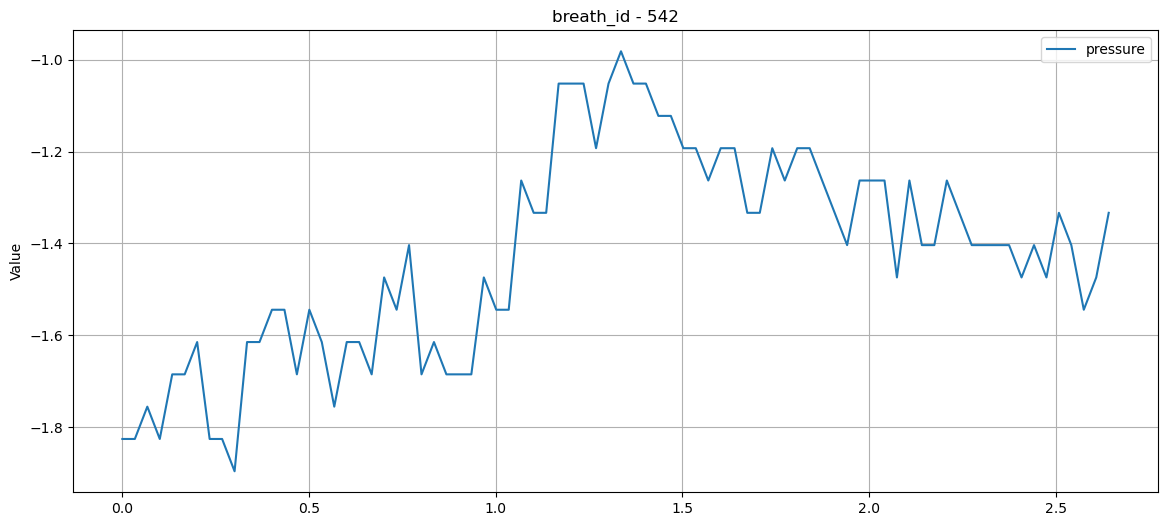

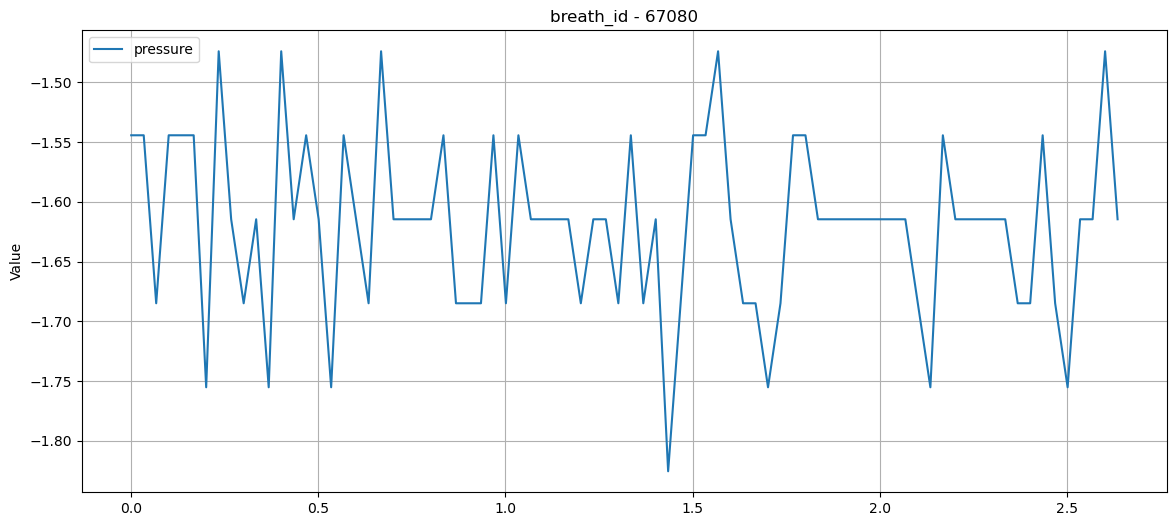

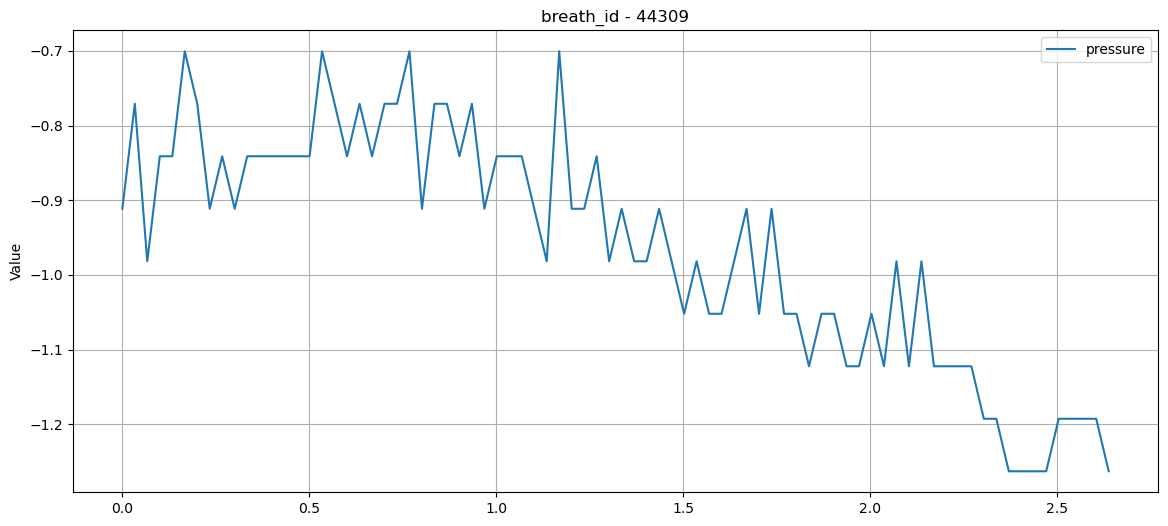

In [53]:
# А теперь посмотрим несколько примеров графиков таргета, где значение таргета меньше 0.
process_visualisation(df_train_nonejection, 542)
process_visualisation(df_train_nonejection, 67080)
process_visualisation(df_train_nonejection, 44309)

У нас 73 цикла дыхания содержащих отрицательное давление. Причем с отрицательным давлением могут быть, как все 80 наблюдений в цикле так и лишь часть. Примеры с отрицательным давлением выглядят визуально не так, как примеры с положительным давлением. Нет более ярко выраженного цикла повышения и спада давления. Вообще, в медицине есть понятие отрицательного давления - это давление ниже атмосферного. Т.е. атмосферное принимается за ноль, а давление ниже атмосферного считается отрицательным. "В плевральной полости давление ниже атмосферного ( «отрицательное»). За счёт отрицательного давления лёгочная плевра плотно прижимается к пристеночной."
Но если бы отрицательное давление было нормой для этих данных, то оно присутствовало бы в большинстве циклов дыхания, а не только в 73 из 75450.  73 из 75450 это 0,097%. Перед обучением придётся удалить данные с отрицательным давлением, как аномальные.

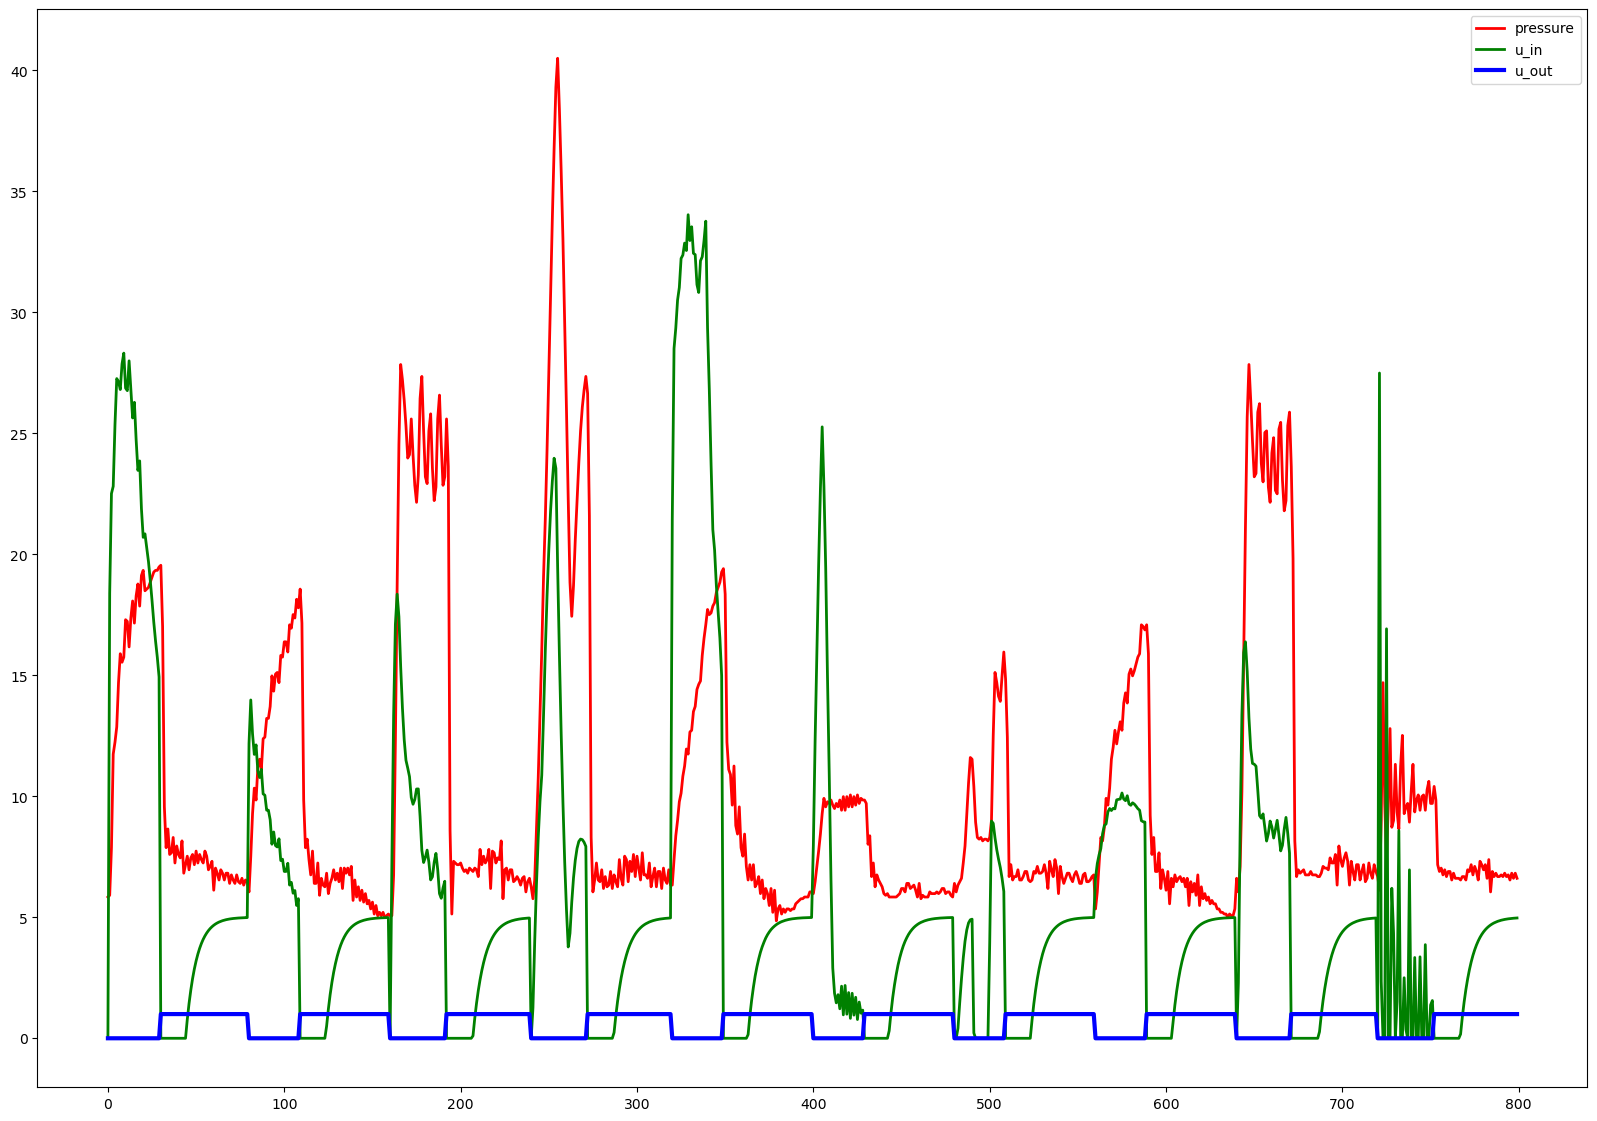

In [59]:
# Посмотрим на графики таргета вместе с признаками u_in и u_out отвечающими за клапаны системы вентиляции легких.
plt.figure(figsize = (20,14))
plt.subplot()
plt.plot(df_train.pressure[:800], linewidth = 2, color = 'r', label="pressure")
plt.plot(df_train.u_in[:800], linewidth = 2, color = 'g', label="u_in")
plt.legend()
plt.subplot()
plt.plot(df_train.u_out[:800], linewidth = 3, color = 'b' , label="u_out")
plt.legend()
plt.show()

Видим, что таргет pressure начинает расти вместе с u_in. Поэтому при генерации признаков признаку u_in нужно будет уделить особое внимание.

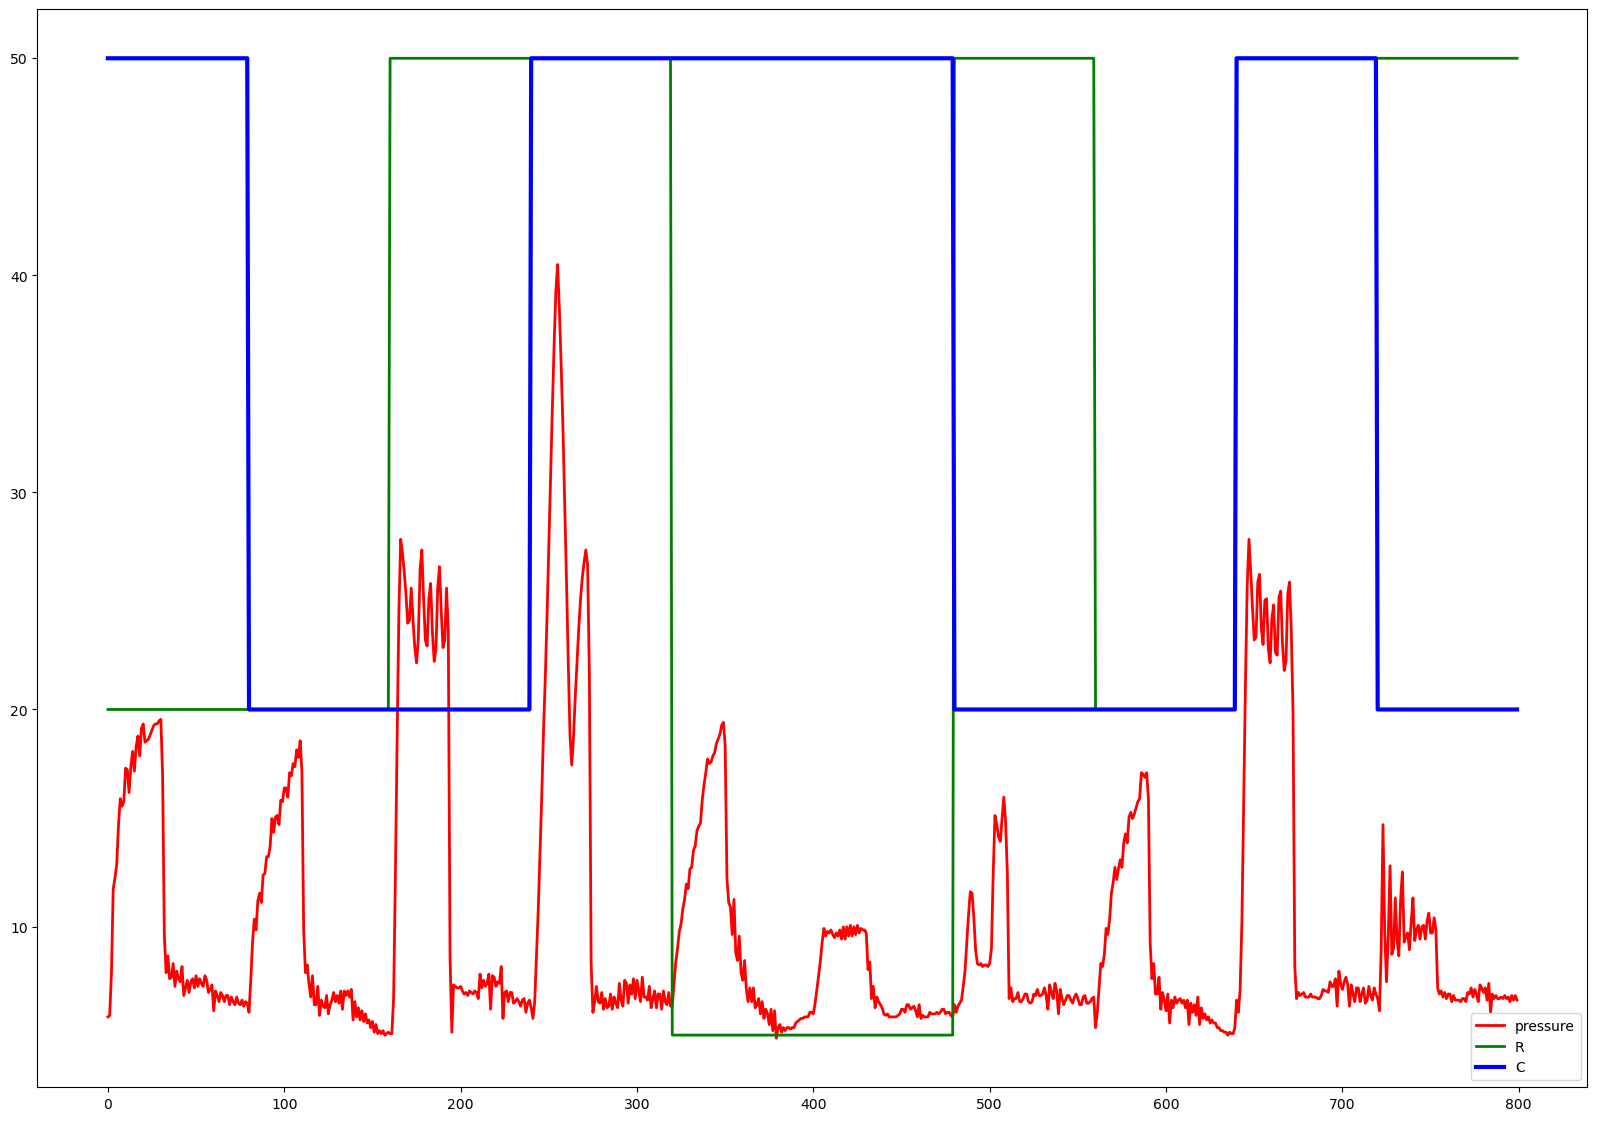

In [61]:
# Посмотрим на графики таргета вместе с признаками C и R.
plt.figure(figsize = (20,14))
plt.subplot()
plt.plot(df_train.pressure[:800], linewidth = 2, color = 'r', label="pressure")
plt.plot(df_train.R[:800], linewidth = 2, color = 'g', label="R")
plt.legend()
plt.subplot()
plt.plot(df_train.C[:800], linewidth = 3, color = 'b' , label="C")
plt.legend()
plt.show()

Визуально на графиках связи таргета с R и C не прослеживается. Чуть ниже, когда будет построена матрица корреляции признаков станет видно, что у R и С очень маленькая корреляция с таргетом.

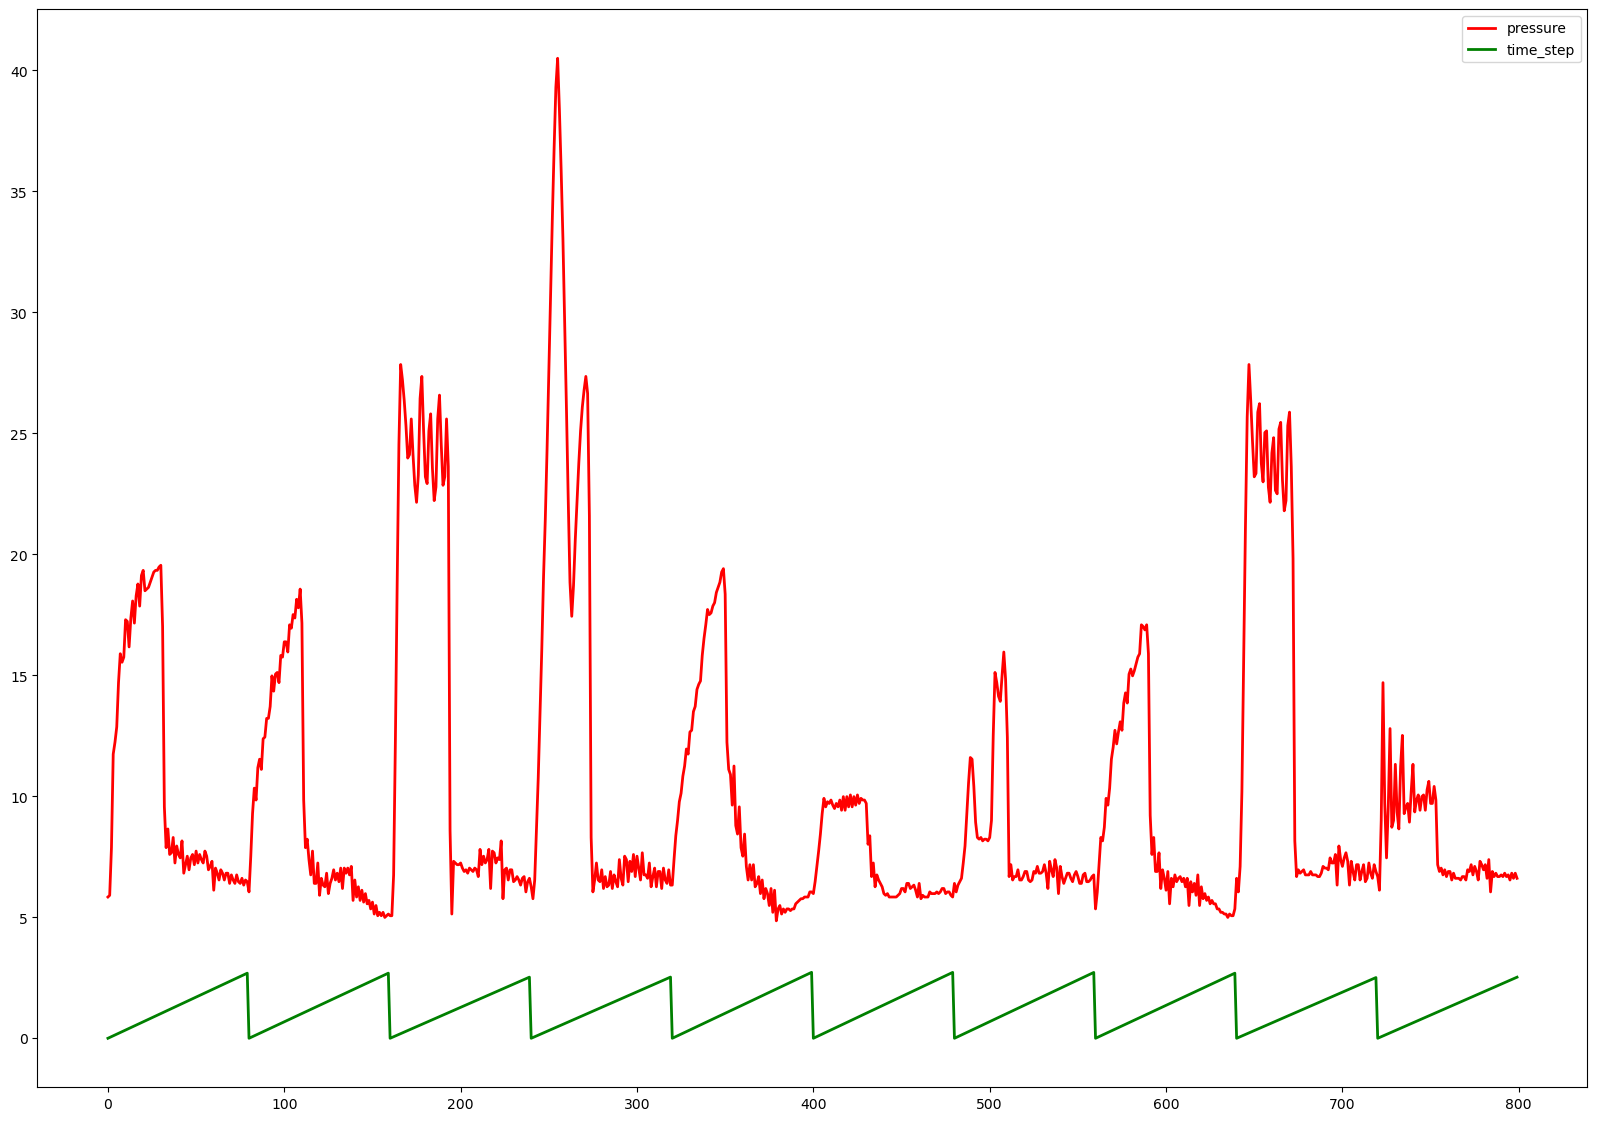

In [63]:
# Посмотрим на графики таргета вместе с признаком time_step.
plt.figure(figsize = (20,14))
plt.subplot()
plt.plot(df_train.pressure[:800], linewidth = 2, color = 'r', label="pressure")
plt.plot(df_train.time_step[:800], linewidth = 2, color = 'g', label="time_step")
plt.legend()
plt.show()

time_step обнуляется в начале каждого цикла дыхания.Как увидим чуть ниже у time_step будет отрицательная корреляция с таргетом. Отрицательная она потому, что в начале, когда time_step маленький давление большое, а под конец цикла, когда time_step большой давление уже маленькое. time_step будем оставлять, как признак.

#### Выводы.

Пропущенных значений в таргете нет. Его значение варьируется от минимума -1.895 до максимума 64.82. Среднее значение 11.22. Половина значений таргета не превышает значение 7.033.
Количество циклов дыхания, где значения таргета превышают правый край усов довольно велико, 38 тысяч из общего количества 75 тысяч дыхательных циклов в данных, т.е. больше половины. И иногда почти половина цикла дыхания состоит из значений превышающих правый край усов. Удаление такого большого количества значений может сказаться при обучении поэтому оставим их. Примеры с отрицательным значением таргета, которых 0,097% от общего числа циклов дыхания  будем удалять. У R и C очень маленькая корреляция с таргетом. Забегая вперед скажу, что я пробовал учить модели оставив R и C и удалив их. В случае удаления этих признаков MAE становилось больше. Поэтому в финальных версиях ноутбуков я оставил R и C.   

## 2. Анализ объектов-признаков
Теперь посмотрим на остальные столбцы, на признаки. 

#### 2.1 Выявление типов и их распределение

In [8]:
df_train.dtypes

id             int64
breath_id      int64
R              int64
C              int64
time_step    float64
u_in         float64
u_out          int64
pressure     float64
dtype: object

In [9]:
df_test.dtypes

id             int64
breath_id      int64
R              int64
C              int64
time_step    float64
u_in         float64
u_out          int64
dtype: object

Все признаки имеют числовые значения: целые числа, числа с плавающей запятой.

<Axes: xlabel='breath_id', ylabel='Count'>

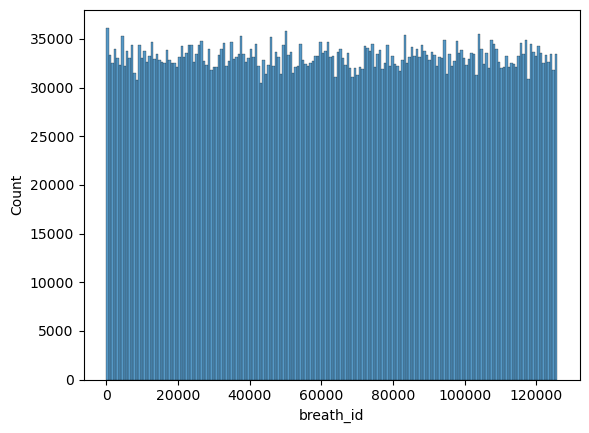

In [66]:
# Построим гистограмму признака breath_id на трейне.breath_id идентификатор цикла дыхания.
sns.histplot(df_train["breath_id"])

<Axes: xlabel='breath_id', ylabel='Count'>

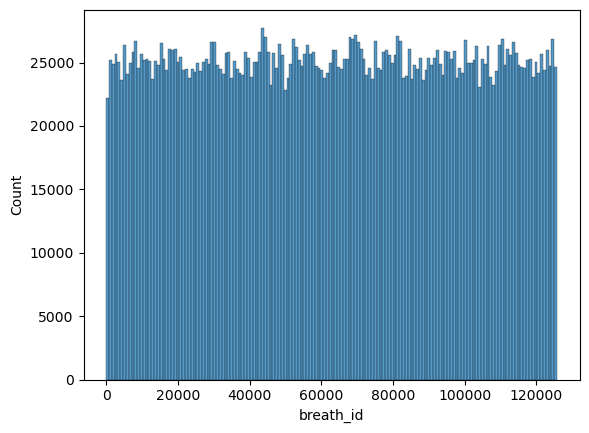

In [67]:
# Построим гистограмму признака breath_id на тесте.
sns.histplot(df_test["breath_id"])

In [68]:
# Посмотрим сколько всего получается циклов дыхания на трейне.
df_train["breath_id"].value_counts()

breath_id
1         80
83891     80
83924     80
83923     80
83922     80
          ..
41745     80
41743     80
41742     80
41741     80
125749    80
Name: count, Length: 75450, dtype: int64

In [69]:
# Посмотрим сколько всего получается циклов дыхания на тесте.
df_test["breath_id"].value_counts()

breath_id
0         80
83714     80
83718     80
83721     80
83722     80
          ..
42208     80
42209     80
42210     80
42211     80
125748    80
Name: count, Length: 50300, dtype: int64

In [70]:
# Посмотрим имеют ли все циклы дыхания на трейне одинаковую длинну.
df_train["breath_id"].value_counts().loc[lambda x : x == 80]

breath_id
1         80
83891     80
83924     80
83923     80
83922     80
          ..
41745     80
41743     80
41742     80
41741     80
125749    80
Name: count, Length: 75450, dtype: int64

In [71]:
# Посмотрим имеют ли все циклы дыхания на тесте одинаковую длинну.
df_test["breath_id"].value_counts().loc[lambda x : x == 80]

breath_id
0         80
83714     80
83718     80
83721     80
83722     80
          ..
42208     80
42209     80
42210     80
42211     80
125748    80
Name: count, Length: 50300, dtype: int64

Да. Каждый цикл дыхания состоит из 80 наблюдений.

<Axes: xlabel='R', ylabel='Count'>

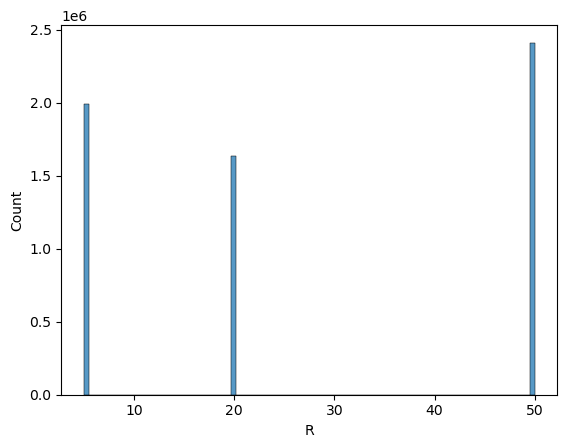

In [72]:
# Построим гистограмму признака R на трейне.
sns.histplot(df_train["R"])

<Axes: xlabel='R', ylabel='Count'>

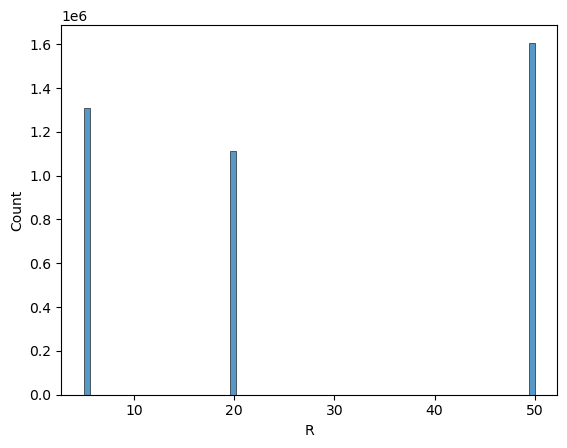

In [73]:
# Построим гистограмму признака R на тесте.
sns.histplot(df_test["R"])

In [74]:
df_train["R"].value_counts()

R
50    2410080
5     1988800
20    1637120
Name: count, dtype: int64

In [75]:
df_test["R"].value_counts()

R
50    1606800
5     1306800
20    1110400
Name: count, dtype: int64

Признак R на трейне и на тесте принимает всего 3 значения: 50, 5, 20. Значение 50 встречается чаще.

<Axes: xlabel='C', ylabel='Count'>

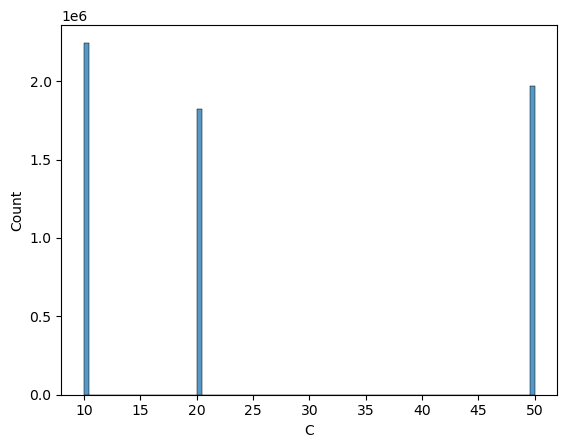

In [76]:
# Построим гистограмму признака C на трейне.
sns.histplot(df_train["C"])

<Axes: xlabel='C', ylabel='Count'>

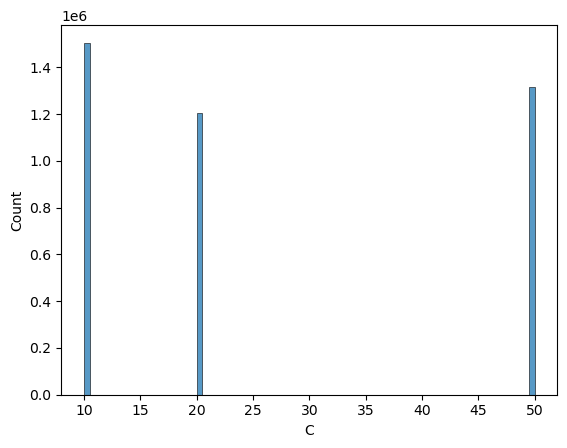

In [77]:
# Построим гистограмму признака C на тесте.
sns.histplot(df_test["C"])

In [78]:
df_train["C"].value_counts()

C
10    2244720
50    1971680
20    1819600
Name: count, dtype: int64

In [79]:
df_test["C"].value_counts()

C
10    1504800
50    1315840
20    1203360
Name: count, dtype: int64

Признак C также принимает всего 3 значения на трейне и тесте: 10, 50, 20. Значение 10 встречается чаще.

<Axes: xlabel='time_step', ylabel='Count'>

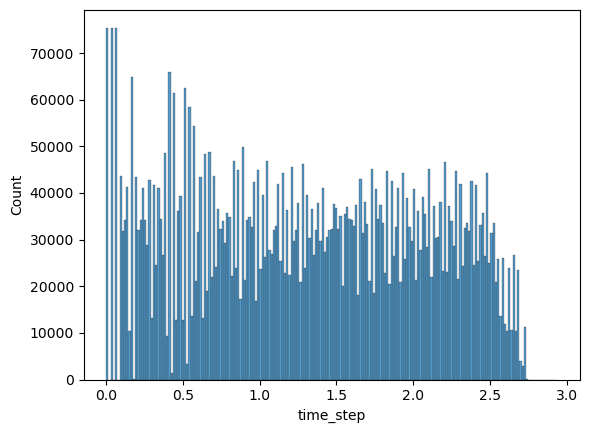

In [80]:
# Построим гистограмму признака time_step на трейне.
sns.histplot(df_train["time_step"])

<Axes: xlabel='time_step', ylabel='Count'>

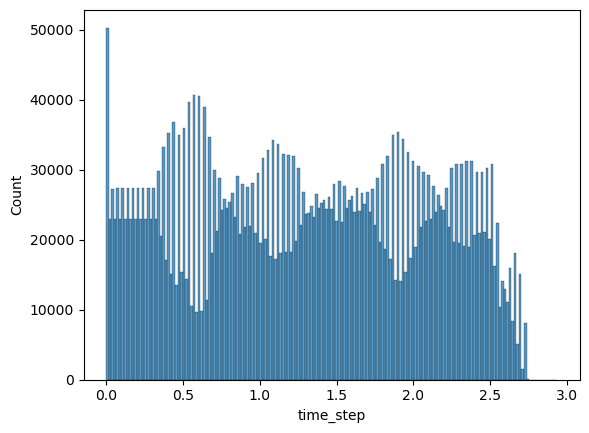

In [81]:
# Построим гистограмму признака time_step на тесте.
sns.histplot(df_test["time_step"])

In [82]:
df_train["time_step"].value_counts()

time_step
0.000000    75450
0.031934       46
0.031935       44
0.031920       43
0.031938       43
            ...  
1.793088        1
1.827272        1
1.896594        1
1.930891        1
2.638017        1
Name: count, Length: 3767571, dtype: int64

In [83]:
df_test["time_step"].value_counts()

time_step
0.000000    50300
0.031927       32
0.031921       30
0.031922       29
0.031923       29
            ...  
0.612732        1
0.544411        1
0.476624        1
0.374591        1
2.665301        1
Name: count, Length: 2855528, dtype: int64

time_step временной шаг цикла дыхания. По значениям видно, что временной шаг обнуляется и в каждом цикле дыхания временной шаг начинается с нуля.

In [84]:
df_train["time_step"].value_counts(bins=3)

time_step
(-0.00394, 0.979]    2266316
(0.979, 1.958]       2231944
(1.958, 2.937]       1537740
Name: count, dtype: int64

In [85]:
df_test["time_step"].value_counts(bins=3)

time_step
(-0.00394, 0.978]    1509730
(0.978, 1.957]       1487368
(1.957, 2.935]       1026902
Name: count, dtype: int64

<Axes: xlabel='u_in', ylabel='Count'>

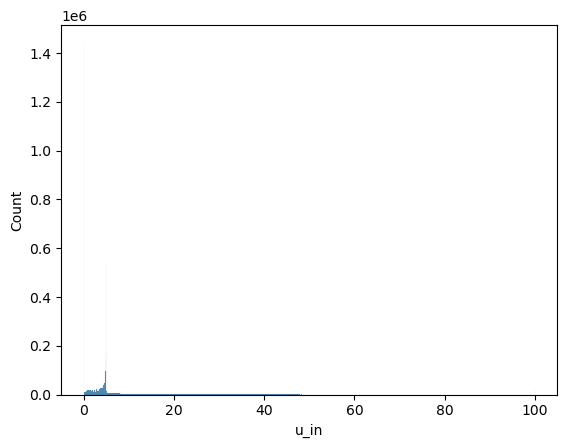

In [86]:
# Построим гистограмму признака u_in на трейне.
sns.histplot(df_train["u_in"])

<Axes: xlabel='u_in', ylabel='Count'>

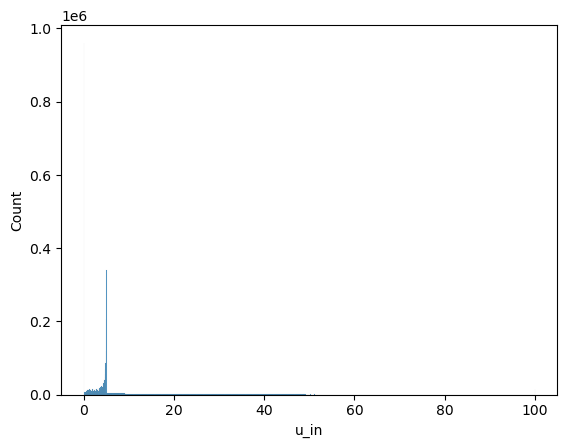

In [87]:
# Построим гистограмму признака u_in на тесте.
sns.histplot(df_test["u_in"])

In [88]:
df_train["u_in"].value_counts()

u_in
0.000000      1432253
100.000000      21739
1.277707           76
1.494747           70
0.058727           67
               ...   
1.116695            1
0.665753            1
0.782097            1
0.615699            1
1.482739            1
Name: count, Length: 4020300, dtype: int64

In [89]:
df_test["u_in"].value_counts()

u_in
0.000000      953408
100.000000     14718
0.073409          48
1.724056          44
2.145869          44
               ...  
4.965943           1
4.971075           1
0.733946           1
1.623114           1
4.985373           1
Name: count, Length: 2787822, dtype: int64

Видим разброс значений признака u_in от 0 до 100.

<Axes: xlabel='u_out', ylabel='Count'>

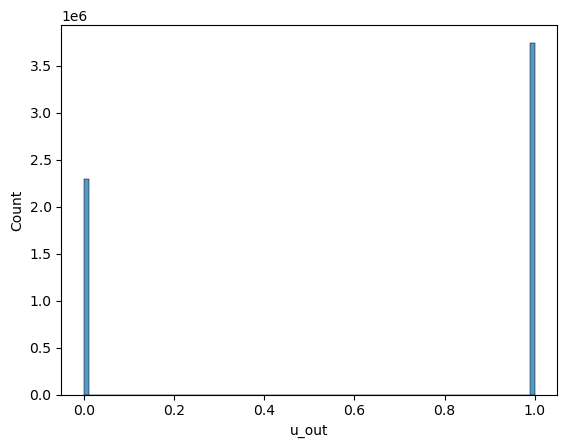

In [90]:
# Построим гистограмму признака u_out на трейне.
sns.histplot(df_train["u_out"])

<Axes: xlabel='u_out', ylabel='Count'>

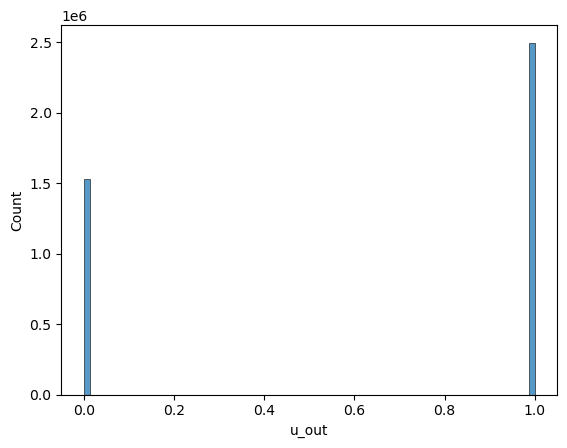

In [91]:
# Построим гистограмму признака u_out на тесте.
sns.histplot(df_test["u_out"])

In [92]:
df_train["u_out"].value_counts()

u_out
1    3745032
0    2290968
Name: count, dtype: int64

In [93]:
df_test["u_out"].value_counts()

u_out
1    2496435
0    1527565
Name: count, dtype: int64

Признак u_out принимает всего 2 значения для трейна и теста: 0 и 1. Значение 1 встречается чаще.

#### 2.2 Выявление аномальных значений признаков

Построим ящики с усами и посмотрим есть ли выбросы.
Для таргета мы смотрели выбросы и аномалии ранее. Кроме того, ранее мы строили гистограммы и выяснили, что 
признаки R и C имеют только 3 значения, а признак u_out только 2.
Поэтому ящики с усами будем строить только для признаков "breath_id", 'time_step', 'u_in'.

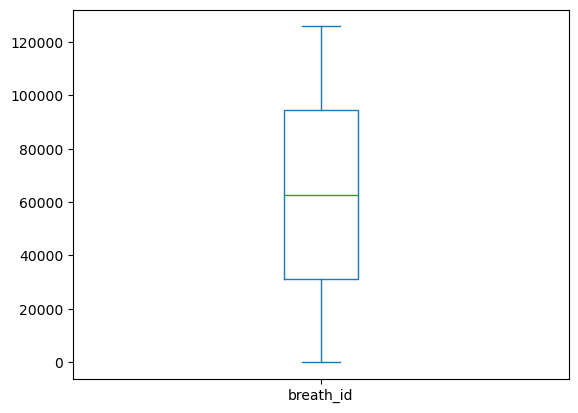

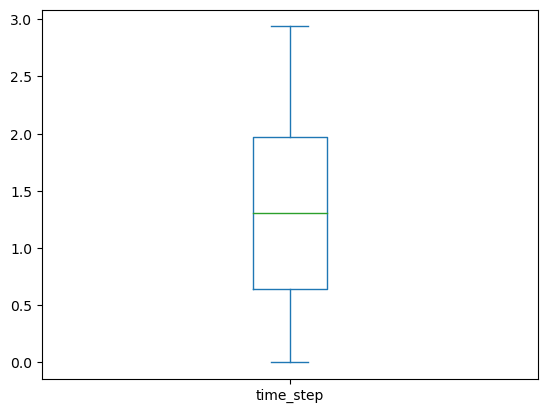

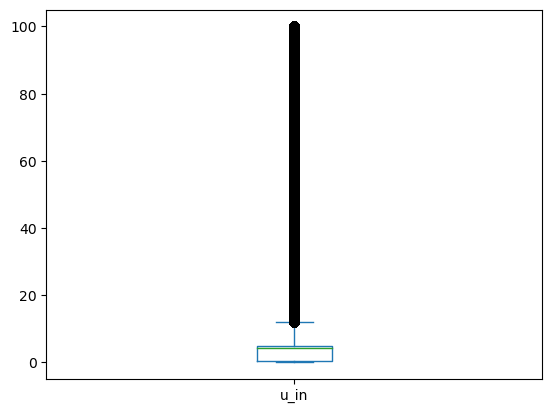

In [94]:
for column in ["breath_id", 'time_step', 'u_in']:
    df_train[column].plot(kind='box')
    plt.show()

Видим, что у признака u_in много значений превышающих правый край усов.

In [95]:
# Найдём правый край усов для u_in на трейне.
q_moustache_uin = find_moustache(df_train['u_in']) 

Первый квантиль =  0
Третий квантиль =  4
Межквартильное расстояние =  4
Правый край усов =  10.0


In [96]:
# Посмотрим на выбросы в u_in. На значения превышающие правый край усов.
df_train_ejection_uin = df_train[df_train['u_in'] > q_moustache_uin]
df_train_ejection_uin.tail(20)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
6035855,6035856,125745,50,50,0.476206,10.491547,0,23.342726
6035857,6035858,125745,50,50,0.539733,10.365003,0,23.483330
6035858,6035859,125745,50,50,0.571460,10.175187,0,23.694237
6035862,6035863,125745,50,50,0.698446,10.428275,0,23.413028
6035921,6035922,125749,50,10,0.033187,25.504196,0,5.345377
6035922,6035923,125749,50,10,0.066365,21.614707,0,9.563505
6035923,6035924,125749,50,10,0.099784,16.266744,0,15.117375
6035924,6035925,125749,50,10,0.133124,16.101221,0,15.468886
6035925,6035926,125749,50,10,0.166506,14.700098,0,17.015533
6035926,6035927,125749,50,10,0.199921,13.117684,0,18.702784


In [99]:
df_train_ejection_uin["breath_id"].value_counts()

breath_id
2398      33
5685      33
67906     32
122328    32
85275     32
          ..
65295      1
65275      1
43772      1
43754      1
105847     1
Name: count, Length: 59316, dtype: int64

Видим, что в 59316 циклов дыхания из 75450 признак u_in превышает правый край усов. Т.е. в 78% случаев. Похоже, что для этих данных это норма.

<Axes: xlabel='u_in', ylabel='Count'>

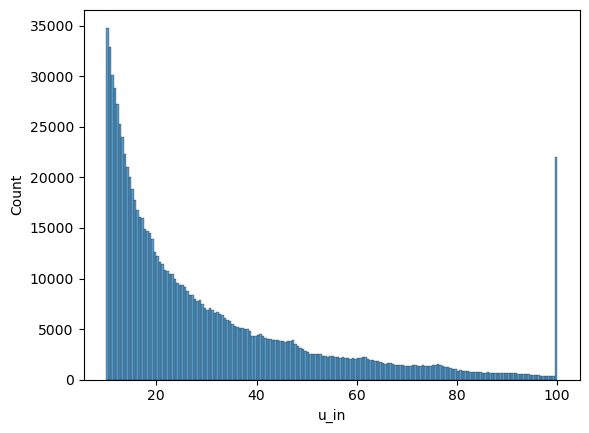

In [100]:
# Построим гистограмму выбросов в u_in.
sns.histplot(df_train_ejection_uin["u_in"])

<Axes: xlabel='u_in', ylabel='Count'>

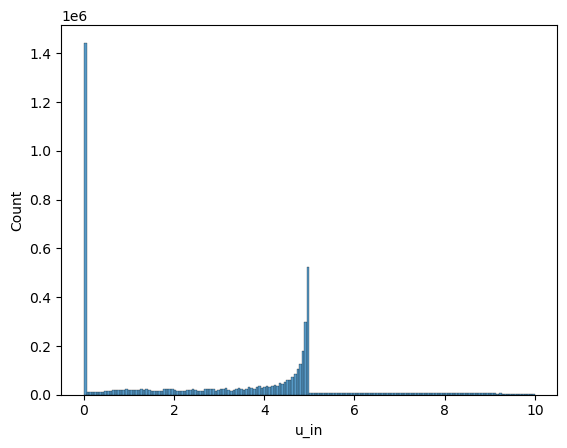

In [101]:
df_train_nonejection_uin = df_train[df_train['u_in'] < q_moustache_uin]

# Построим гистограмму без выбросов в u_in.
sns.histplot(df_train_nonejection_uin["u_in"])

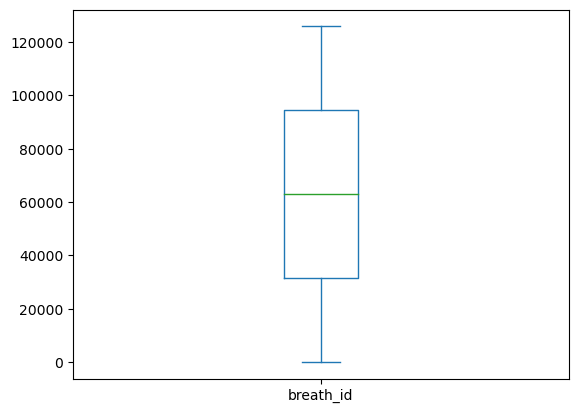

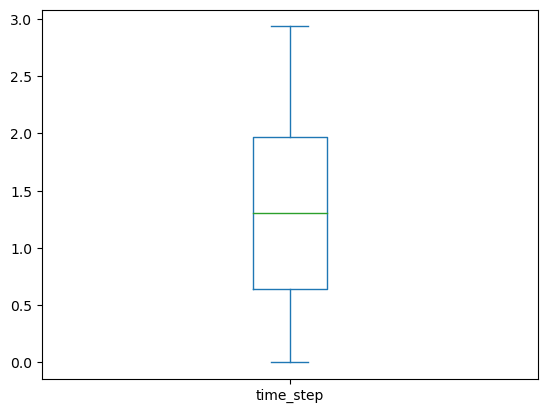

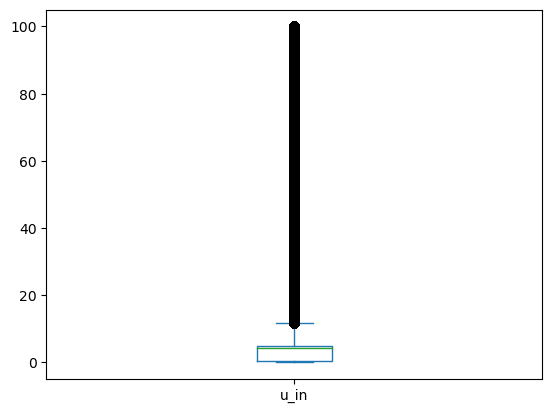

In [102]:
# Теперь посмотрим на тест.
for column in ["breath_id", 'time_step', 'u_in']:
    df_test[column].plot(kind='box')
    plt.show()

In [103]:
# Найдём правый край усов для u_in на тесте.
q_moustache_uin_test = find_moustache(df_test['u_in']) 

Первый квантиль =  0
Третий квантиль =  4
Межквартильное расстояние =  4
Правый край усов =  10.0


In [104]:
df_test_ejection_uin = df_test[df_test['u_in'] > q_moustache_uin_test]
df_test_nonejection_uin = df_test[df_test['u_in'] < q_moustache_uin_test]

In [106]:
df_test["breath_id"].value_counts()

breath_id
0         80
83714     80
83718     80
83721     80
83722     80
          ..
42208     80
42209     80
42210     80
42211     80
125748    80
Name: count, Length: 50300, dtype: int64

In [105]:
df_test_ejection_uin["breath_id"].value_counts()

breath_id
488       33
110637    32
54615     32
55567     32
2534      32
          ..
45171      1
45281      1
45319      1
90995      1
117521     1
Name: count, Length: 39437, dtype: int64

На тесте в 39437 циклах дыхания из 50300, т.е. в 78% случаях признак u_in также, как и на трейне превышает правый край усов.

<Axes: xlabel='u_in', ylabel='Count'>

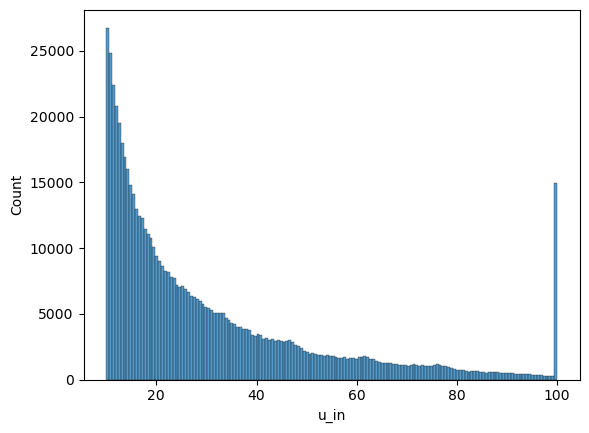

In [65]:
# Построим гистограмму выбросов в u_in на тесте.
sns.histplot(df_test_ejection_uin["u_in"])

<Axes: xlabel='u_in', ylabel='Count'>

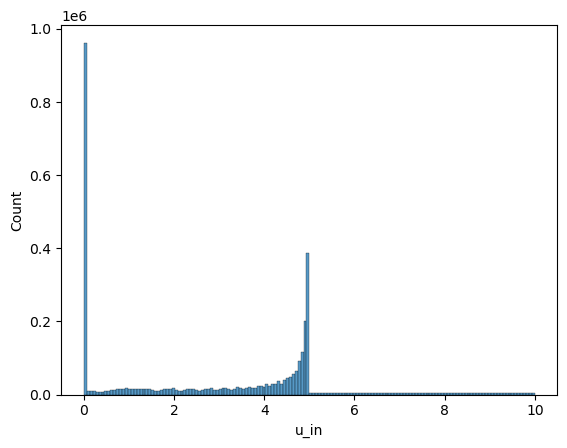

In [66]:
# Построим гистограмму без выбросов в u_in на тесте.
sns.histplot(df_test_nonejection_uin["u_in"])

#### 2.3 Выявление зависимых признаков
Посмотрим на корреляцию для выявления зависимых признаков. Сначала посмотрим в таблицах, потом на тепловой карте.

In [11]:
df_train.corr()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
id,1.000000,0.999999,0.001853,0.007222,-0.000199,-0.002380,-0.000089,-0.002402
breath_id,0.999999,1.000000,0.001860,0.007222,-0.000213,-0.002378,-0.000100,-0.002394
R,0.001853,0.001860,1.000000,-0.096070,-0.014535,-0.148120,-0.007594,0.015976
C,0.007222,0.007222,-0.096070,1.000000,0.004936,0.151002,0.003720,-0.036727
time_step,-0.000199,-0.000213,-0.014535,0.004936,1.000000,-0.352276,0.839191,-0.524829
u_in,-0.002380,-0.002378,-0.148120,0.151002,-0.352276,1.000000,-0.416985,0.308136
u_out,-0.000089,-0.000100,-0.007594,0.003720,0.839191,-0.416985,1.000000,-0.614910
pressure,-0.002402,-0.002394,0.015976,-0.036727,-0.524829,0.308136,-0.614910,1.000000


In [12]:
df_test.corr()

,id,breath_id,R,C,time_step,u_in,u_out
id,1.000000,0.999998,0.002978,-0.003102,-0.000169,-0.002049,-0.000118
breath_id,0.999998,1.000000,0.002983,-0.003115,-0.000188,-0.002039,-0.000135
R,0.002978,0.002983,1.000000,-0.093566,-0.014633,-0.151597,-0.007784
C,-0.003102,-0.003115,-0.093566,1.000000,0.004931,0.153041,0.003774
time_step,-0.000169,-0.000188,-0.014633,0.004931,1.000000,-0.352357,0.839221
u_in,-0.002049,-0.002039,-0.151597,0.153041,-0.352357,1.000000,-0.417020
u_out,-0.000118,-0.000135,-0.007784,0.003774,0.839221,-0.417020,1.000000


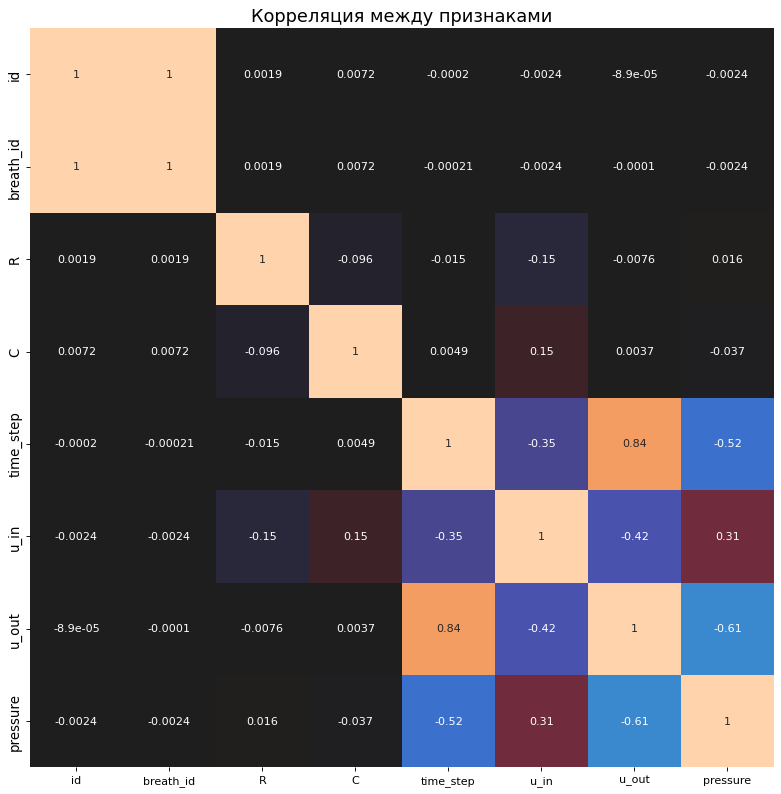

In [67]:
show_correlogram(df_train)

У каких-то признаков отрицательная корреляция с таргетом, как у u_out.
У каких-то положительная, как у u_in.
А у некоторых корреляция очень маленькая, в районе нуля  - C, R, поэтому потребуется генерация новых признаков.
Признак u_in показал самую высокую положительную корреляцию с таргетом. Поэтому ему стоит уделить особое внимание при генерировании новых признаков.

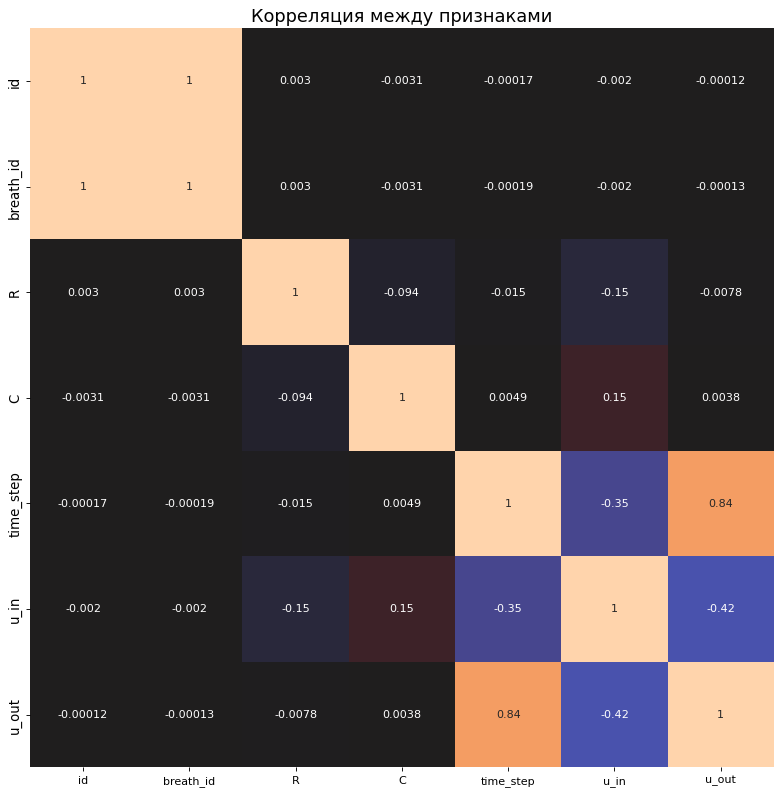

In [13]:
show_correlogram(df_test)

#### 2.4 Выявление пропущенных значений.

In [40]:
df_train.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

In [10]:
df_test.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
dtype: int64

Пропущенных значений нет.

#### 2.5 Выявление важных признаков (различные корреляции с таргетом)

Теперь посмотрим на корреляцию наших признаков с таргетом более подробно графически.
Для визуализации взаимосвязи будем использовать plt.scatter

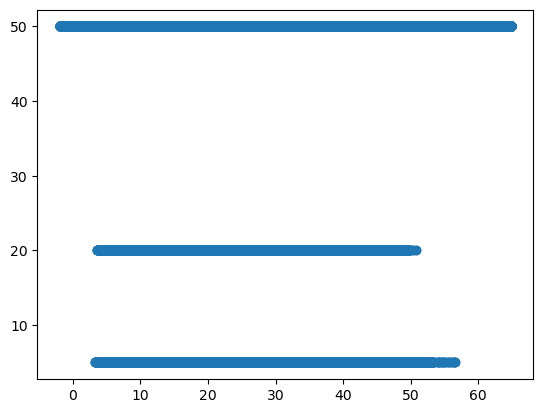

In [41]:
plt.scatter(df_train["pressure"], df_train["R"])

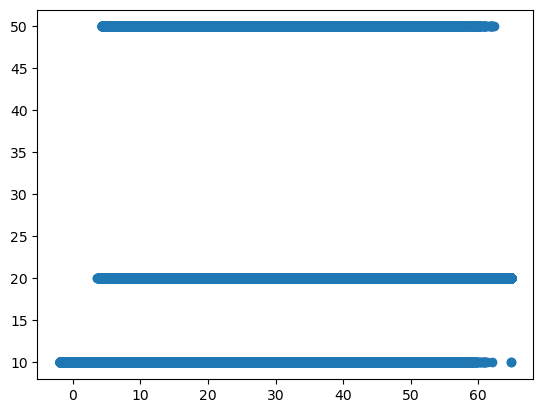

In [42]:
plt.scatter(df_train["pressure"], df_train["C"])

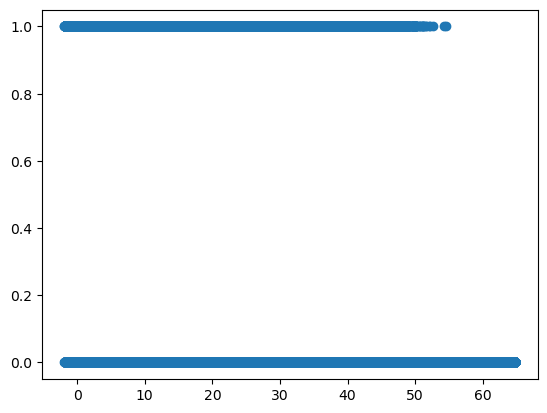

In [43]:
plt.scatter(df_train["pressure"], df_train["u_out"])

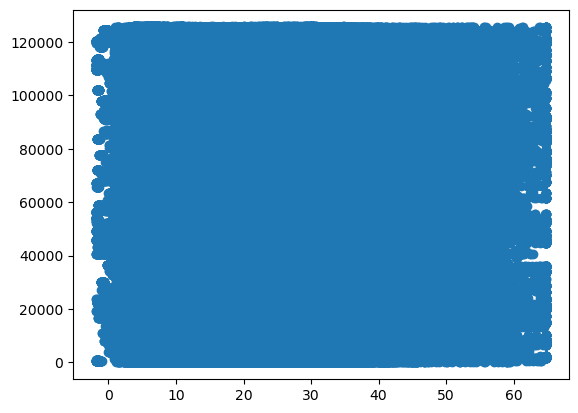

In [44]:
plt.scatter(df_train["pressure"], df_train["breath_id"])

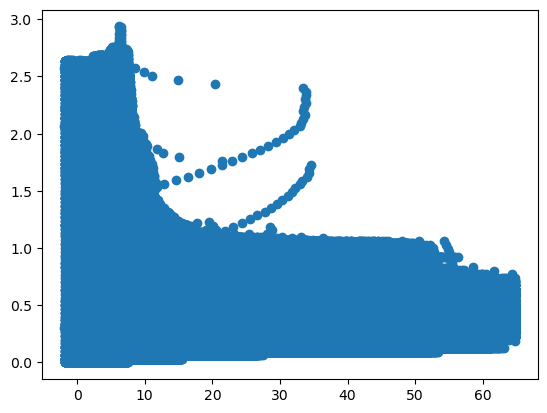

In [45]:
plt.scatter(df_train["pressure"], df_train["time_step"])

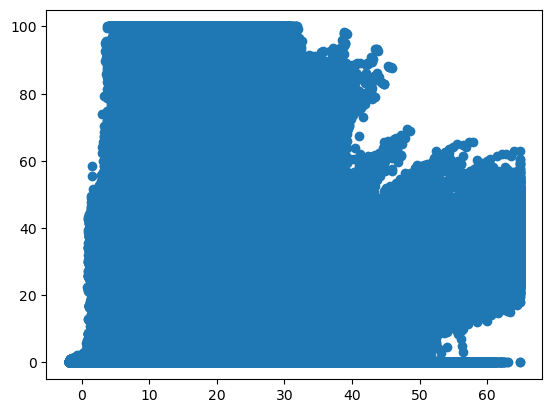

In [46]:
plt.scatter(df_train["pressure"], df_train["u_in"])

Супер очевидной связи на диаграммах рассения не прослеживается. Но чуть выше мы смотрели общую матрицу корреляции по всем столбцам датафрейма и там прослеживалась зависимость некоторых признаков.

#### 2.6 Анализ возможных преобразования и генерации новых признаков

Данные представляют собой циклы дыхания одинаковой длины. И, как мы выяснили выше каждый цикл дыхания состоит из 80 наблюдений. В наблюдении фиксируется несколько параметров. Признаки C и R показали очень маленькую корреляцию на диаграмме и их хочется удалить. Забегая вперед, скажу, что удаление R и C ухудшило результаты, поэтому в финальной версии ноутбуков я решил эти два признака оставить. 
Удалим примеры, где таргет - давление имеет отрицательное значение, так как это похоже на аномалию.
Изучение статей на тему временных рядов показало, что для генерации признаков в задачах с временными рядами применяют примерно одни и те же приёмы: скользящие окна, расширяющиеся окна, пики, эксцессы, лаги (положительные и отрицательные), вычисление среднего, медианы, дисперсии, максимума, минимума, кумулятивной суммы и т.д. с последующим добавление новой информации к исходным данным в качестве новых признаков.
Пример такой статьи с описанием методов можно почитать здесь https://habr.com/ru/articles/584896/

Было решено попробовать 3 версии фича инжиниринга и просто в порядке эксперимента сравнить их.

1) Добавить только лаги с шагом 1, 2 и -1, -2 для признака u_in.
2) Добавить только кумулятивную сумму, минимум, максимум, медиану, первое и последнее значение ряда для признака u_in.
3) Объединение первых двух методов.

На датасете каждой версии фича инжиниринга будет обучено несколько моделей LAMA. 
Таким образом будет найден лучший подход по генерации признака.
В дальнейшем именно на таком подходе будет учиться что-то, что должно превзойти LAMA.

3 Функции для генерации признаков. В следующем ноутбуке с бейзлайном по LAMA будем экспериментировать с этими фунуциями.

In [120]:
# Функция добавляет лаги с шагом 1, 2 и -1, -2 к признаку u_in. 
def generate_features_v1(df):
    data = copy.deepcopy(df)
    data['u_in_lag_1'] = data.groupby('breath_id')['u_in'].shift(1)
    data['u_in_lag_2'] = data.groupby('breath_id')['u_in'].shift(2)
    data['u_in_lag_-1'] = data.groupby('breath_id')['u_in'].shift(-1)
    data['u_in_lag_-2'] = data.groupby('breath_id')['u_in'].shift(-2)
    data = data.fillna(0)
    data_pressure_subzero = data[data['pressure'] < 0]
    pressure_subzero_id = list(set(data_pressure_subzero.breath_id.values))
    data = data[data['breath_id'].apply(lambda x: x not in pressure_subzero_id)]
    
    return data


# Функция добавляет кумулятивную сумму, первое/последнее значение, минимум/максимум, медиану признака u_in. 
def generate_features_v2(df):
    data = copy.deepcopy(df)
    data['u_in_cumsum'] = data['u_in'].groupby(data['breath_id']).cumsum()
    data['u_in_first'] = data.groupby('breath_id')['u_in'].transform('first')
    data['u_in_last'] = data.groupby('breath_id')['u_in'].transform('last')
    data['u_in_min'] = data.groupby('breath_id')['u_in'].transform('min')
    data['u_in_max'] = data.groupby('breath_id')['u_in'].transform('max')
    data['u_in_median'] = data.groupby('breath_id')['u_in'].transform('median')
    data = data.fillna(0)
    data_pressure_subzero = data[data['pressure'] < 0]
    pressure_subzero_id = list(set(data_pressure_subzero.breath_id.values))
    data = data[data['breath_id'].apply(lambda x: x not in pressure_subzero_id)]
    
    return data


# Функция объединяет добавление признаков из первых двух версий функции.
def generate_features_v3(df):
    data = copy.deepcopy(df)
    data['u_in_lag_1'] = data.groupby('breath_id')['u_in'].shift(1)
    data['u_in_lag_2'] = data.groupby('breath_id')['u_in'].shift(2)
    data['u_in_lag_-1'] = data.groupby('breath_id')['u_in'].shift(-1)
    data['u_in_lag_-2'] = data.groupby('breath_id')['u_in'].shift(-2)
    data['u_in_cumsum'] = data['u_in'].groupby(data['breath_id']).cumsum()
    data['u_in_first'] = data.groupby('breath_id')['u_in'].transform('first')
    data['u_in_last'] = data.groupby('breath_id')['u_in'].transform('last')
    data['u_in_min'] = data.groupby('breath_id')['u_in'].transform('min')
    data['u_in_max'] = data.groupby('breath_id')['u_in'].transform('max')
    data['u_in_median'] = data.groupby('breath_id')['u_in'].transform('median')
    data = data.fillna(0)
    data_pressure_subzero = data[data['pressure'] < 0]
    pressure_subzero_id = list(set(data_pressure_subzero.breath_id.values))
    data = data[data['breath_id'].apply(lambda x: x not in pressure_subzero_id)]
    
    return data

In [121]:
# Сгенерируем новые признаки тремя разными функциями.
df_train_v1 = generate_features_v1(df_train)
df_train_v2 = generate_features_v2(df_train)
df_train_v3 = generate_features_v3(df_train)

In [122]:
df_train_v1

,id,breath_id,time_step,u_in,u_out,pressure,u_in_lag_1,u_in_lag_2,u_in_lag_-1,u_in_lag_-2
0,1,1,0.000000,0.083334,0,5.837492,0.000000,0.000000,18.383041,22.509278
1,2,1,0.033652,18.383041,0,5.907794,0.083334,0.000000,22.509278,22.808822
2,3,1,0.067514,22.509278,0,7.876254,18.383041,0.083334,22.808822,25.355850
3,4,1,0.101542,22.808822,0,11.742872,22.509278,18.383041,25.355850,27.259866
4,5,1,0.135756,25.355850,0,12.234987,22.808822,22.509278,27.259866,27.127486
...,...,...,...,...,...,...,...,...,...,...
6035995,6035996,125749,2.504603,1.489714,1,3.869032,1.420711,1.353205,1.488497,1.558978
6035996,6035997,125749,2.537961,1.488497,1,3.869032,1.489714,1.420711,1.558978,1.272663
6035997,6035998,125749,2.571408,1.558978,1,3.798729,1.488497,1.489714,1.272663,1.482739
6035998,6035999,125749,2.604744,1.272663,1,4.079938,1.558978,1.488497,1.482739,0.000000


In [123]:
df_train_v1['breath_id'].value_counts()

breath_id
1         80
83892     80
83925     80
83924     80
83923     80
          ..
41731     80
41727     80
41726     80
41725     80
125749    80
Name: count, Length: 75377, dtype: int64

Видим, что циклов дыхания стало на 73 меньше. Удалены все аномальные примеры, где таргет был отрицательным.

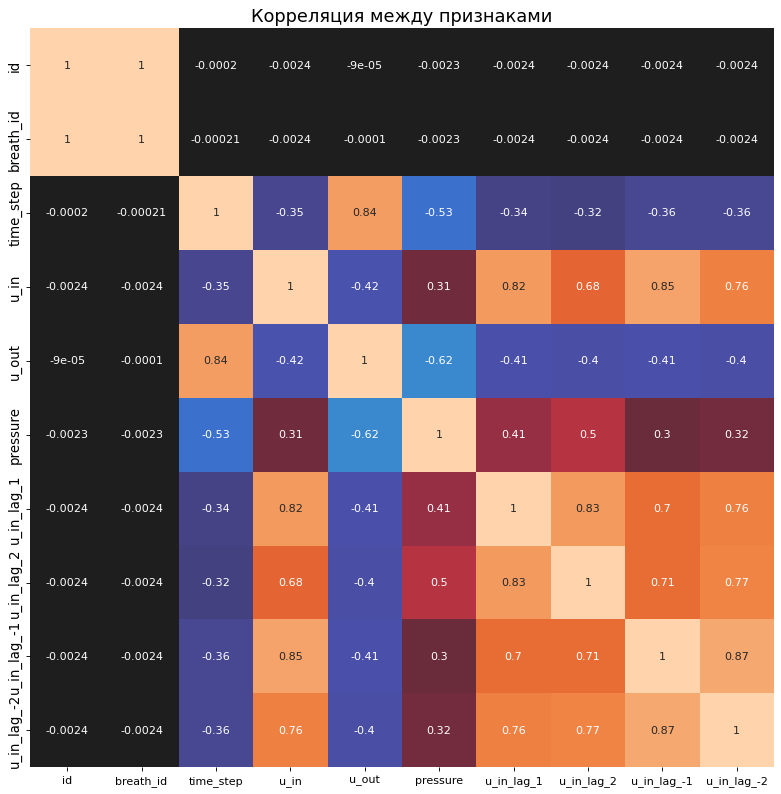

In [124]:
show_correlogram(df_train_v1)

In [125]:
df_train_v2

,id,breath_id,time_step,u_in,u_out,pressure,u_in_cumsum,u_in_first,u_in_last,u_in_min,u_in_max,u_in_median
0,1,1,0.000000,0.083334,0,5.837492,0.083334,0.083334,4.987079,0.0,28.313036,4.922568
1,2,1,0.033652,18.383041,0,5.907794,18.466375,0.083334,4.987079,0.0,28.313036,4.922568
2,3,1,0.067514,22.509278,0,7.876254,40.975653,0.083334,4.987079,0.0,28.313036,4.922568
3,4,1,0.101542,22.808822,0,11.742872,63.784476,0.083334,4.987079,0.0,28.313036,4.922568
4,5,1,0.135756,25.355850,0,12.234987,89.140326,0.083334,4.987079,0.0,28.313036,4.922568
...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,6035996,125749,2.504603,1.489714,1,3.869032,387.109297,6.030572,1.482739,0.0,25.504196,1.694180
6035996,6035997,125749,2.537961,1.488497,1,3.869032,388.597794,6.030572,1.482739,0.0,25.504196,1.694180
6035997,6035998,125749,2.571408,1.558978,1,3.798729,390.156772,6.030572,1.482739,0.0,25.504196,1.694180
6035998,6035999,125749,2.604744,1.272663,1,4.079938,391.429435,6.030572,1.482739,0.0,25.504196,1.694180


In [126]:
df_train_v2['breath_id'].value_counts()

breath_id
1         80
83892     80
83925     80
83924     80
83923     80
          ..
41731     80
41727     80
41726     80
41725     80
125749    80
Name: count, Length: 75377, dtype: int64

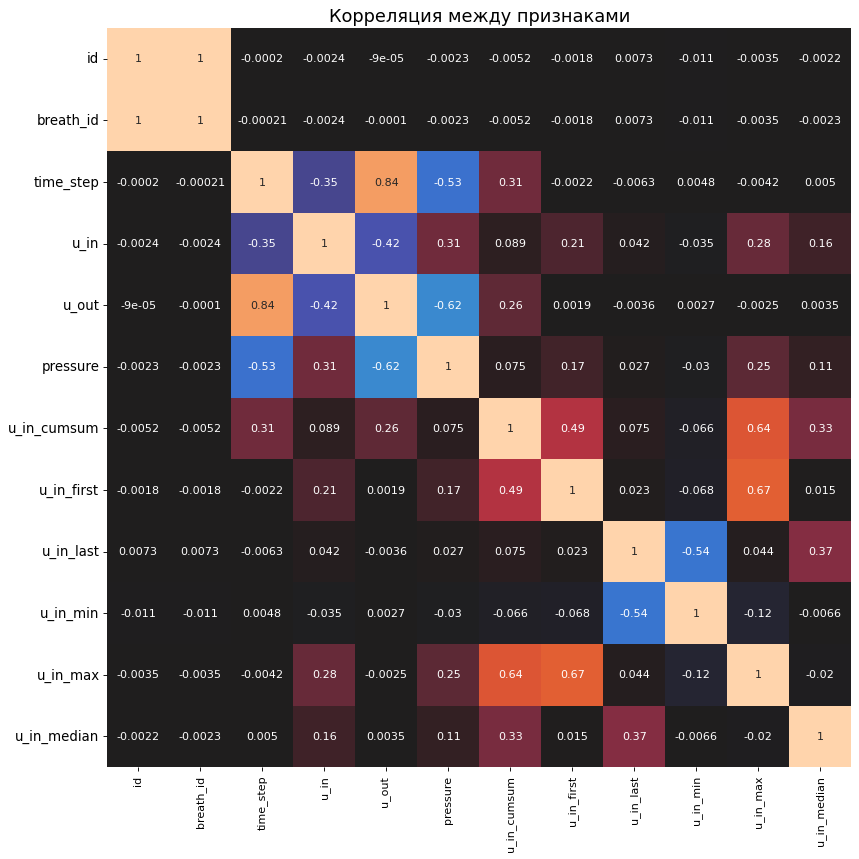

In [127]:
show_correlogram(df_train_v2)

In [128]:
df_train_v3

,id,breath_id,time_step,u_in,u_out,pressure,u_in_lag_1,u_in_lag_2,u_in_lag_-1,u_in_lag_-2,u_in_cumsum,u_in_first,u_in_last,u_in_min,u_in_max,u_in_median
0,1,1,0.000000,0.083334,0,5.837492,0.000000,0.000000,18.383041,22.509278,0.083334,0.083334,4.987079,0.0,28.313036,4.922568
1,2,1,0.033652,18.383041,0,5.907794,0.083334,0.000000,22.509278,22.808822,18.466375,0.083334,4.987079,0.0,28.313036,4.922568
2,3,1,0.067514,22.509278,0,7.876254,18.383041,0.083334,22.808822,25.355850,40.975653,0.083334,4.987079,0.0,28.313036,4.922568
3,4,1,0.101542,22.808822,0,11.742872,22.509278,18.383041,25.355850,27.259866,63.784476,0.083334,4.987079,0.0,28.313036,4.922568
4,5,1,0.135756,25.355850,0,12.234987,22.808822,22.509278,27.259866,27.127486,89.140326,0.083334,4.987079,0.0,28.313036,4.922568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,6035996,125749,2.504603,1.489714,1,3.869032,1.420711,1.353205,1.488497,1.558978,387.109297,6.030572,1.482739,0.0,25.504196,1.694180
6035996,6035997,125749,2.537961,1.488497,1,3.869032,1.489714,1.420711,1.558978,1.272663,388.597794,6.030572,1.482739,0.0,25.504196,1.694180
6035997,6035998,125749,2.571408,1.558978,1,3.798729,1.488497,1.489714,1.272663,1.482739,390.156772,6.030572,1.482739,0.0,25.504196,1.694180
6035998,6035999,125749,2.604744,1.272663,1,4.079938,1.558978,1.488497,1.482739,0.000000,391.429435,6.030572,1.482739,0.0,25.504196,1.694180


In [129]:
df_train_v3['breath_id'].value_counts()

breath_id
1         80
83892     80
83925     80
83924     80
83923     80
          ..
41731     80
41727     80
41726     80
41725     80
125749    80
Name: count, Length: 75377, dtype: int64

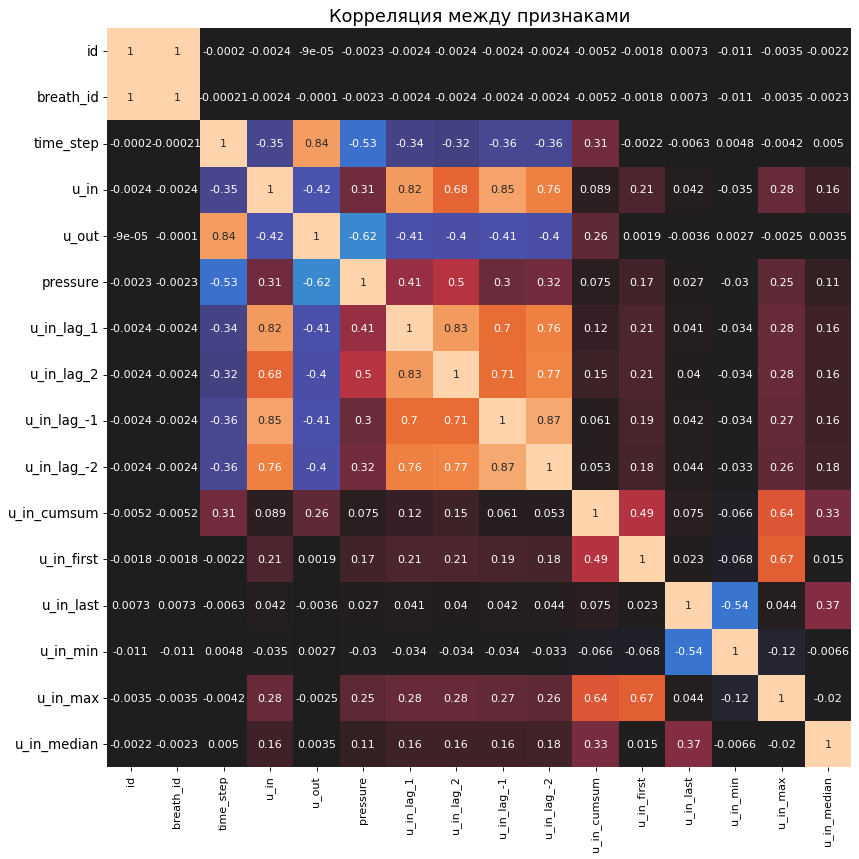

In [130]:
show_correlogram(df_train_v3)

#### В следующем ноутбуке будем учить разные варианты LAMA на разных вариантах признаков. 